Shape of GeoDataFrame: (2949, 37)
Original Variable Names: Index(['OBJECTID', 'ID', 'NAME', 'ADDRESS', 'CITY', 'STATE', 'ZIP',
       'TELEPHONE', 'TYPE', 'COUNTRY', 'NAICS_CODE', 'NAICS_DESC', 'SOURCE',
       'SOURCEDATE', 'VAL_METHOD', 'VAL_DATE', 'WEBSITE', 'REGULATED',
       'CNTRL_AREA', 'PLAN_AREA', 'HOLDING_CO', 'SUMMR_PEAK', 'WINTR_PEAK',
       'SUMMER_CAP', 'WINTER_CAP', 'NET_GEN', 'PURCHASED', 'NET_EX',
       'RETAIL_MWH', 'WSALE_MWH', 'TOTAL_MWH', 'TRANS_MWH', 'CUSTOMERS',
       'YEAR', 'Shape__Are', 'Shape__Len', 'geometry'],
      dtype='object')
Modified Variable Names: Index(['OBJECTID', 'ID', 'NAME', 'ADDRESS', 'CITY', 'STATE', 'ZIP',
       'TELEPHONE', 'TYPE', 'COUNTRY', 'NAICS_CODE', 'NAICS_DESC', 'SOURCE',
       'SOURCEDATE', 'VAL_METHOD', 'VAL_DATE', 'WEBSITE', 'REGULATED',
       'CNTRL_AREA', 'PLAN_AREA', 'HOLDING_CO', 'SUMMR_PEAK', 'WINTR_PEAK',
       'SUMMER_CAP', 'WINTER_CAP', 'NET_GEN', 'PURCHASED', 'NET_EX',
       'RETAIL_MWH', 'WSALE_MWH', 'TOTAL_MW

<AxesSubplot:>

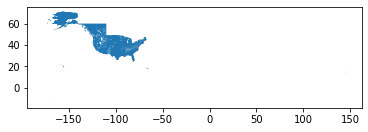

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile
shapefile_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/Electric_Retail_Service_Territories.shp'
ba_subregions = gpd.read_file(shapefile_path)
# Filter for 'PJM INTERCONNECTION, LLC' in 'CNTRL_AREA'
pjm_subregions = ba_subregions[ba_subregions['CNTRL_AREA'] == 'PJM INTERCONNECTION, LLC']
# Adjust column names to replace spaces with underscores
ba_subregions.columns = [col.replace(' ', '_') for col in ba_subregions.columns]

# Define a function for plotting
def plot_subregions_with_multiple_annotations(gdf, title):
    fig, ax = plt.subplots(figsize=(18, 10))
    # Assign unique colors based on 'CNTRL_AREA'
    gdf['color'] = gdf['CNTRL_AREA'].astype('category').cat.codes
    gdf.plot(ax=ax, edgecolor='black', column='color', cmap='Set3', legend=True, alpha=0.5)
    
    # Annotate with 'ID' and 'NAME'
    for idx, row in gdf.iterrows():
        centroid = row.geometry.centroid
        ax.text(centroid.x, centroid.y, f"{str(row['ID'])}\n{row['NAME']}", fontsize=8, ha='center', va='center', color='black')
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

# Now, plot the subregions with annotations by 'CNTRL_AREA'
plot_subregions_with_multiple_annotations(ba_subregions, 'Subregions by CNTRL_AREA')


/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


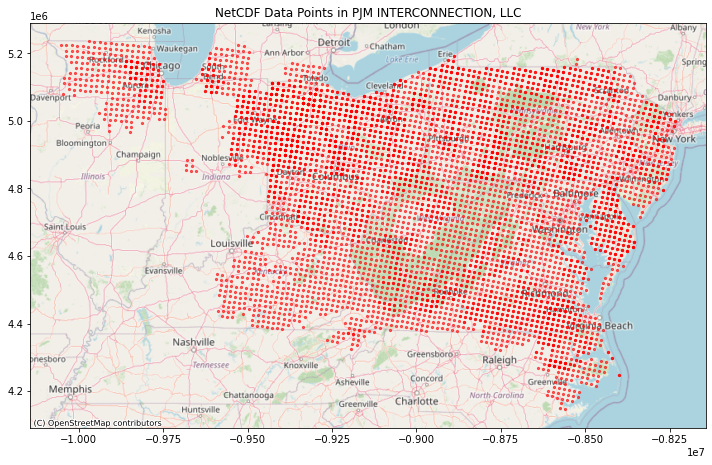

In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import pandas as pd
from shapely.geometry import Point
import contextily as ctx
control_area_mapping = {
    "CommEd": ["COMMONWEALTH EDISON CO"],
    "EKPC": ["EAST KENTUCKY POWER COOP, INC"],
    "DEO&K": ["DUKE ENERGY KENTUCKY", "DUKE ENERGY OHIO INC"],
    "Day": ["DAYTON POWER & LIGHT CO"],
    "ATSI": ["THE TOLEDO EDISON CO", "OHIO EDISON CO", "PENNSYLVANIA POWER CO"],
    "OVEC": ["OHIO VALLEY ELECTRIC CORP"],
    "AEP": ["OHIO POWER CO", "KENTUCKY POWER CO", "APPALACHIAN POWER CO"],
    "AP": ["WEST PENN POWER COMPANY", "MONONGAHELA POWER CO"],
    "Dominion": ["VIRGINIA ELECTRIC & POWER CO", "RAPPAHANNOCK ELECTRIC COOP"],
    "DP&L": ["MONONGAHELA POWER CO", "CITY OF SEAFORD- (DE)", "TOWN OF SMYRNA - (DE)", "CHOPTANK ELECTRIC COOPERATIVE, INC"],
    "PEPCO": ["SOUTHERN MARYLAND ELEC COOP INC", "POTOMAC ELECTRIC POWER CO"],
    "BGE": ["BALTIMORE GAS & ELECTRIC CO"],
    "AE": ["ATLANTIC CITY ELECTRIC CO", "CITY OF VINELAND - (NJ)"],
    "JCP&L": ["JERSEY CENTRAL POWER & LT CO"],
    "PSEG": ["PUBLIC SERVICE ELEC & GAS CO"],
    "RECO": ["ROCKLAND ELECTRIC CO"],
    "PECO": ["PECO ENERGY CO"],
    "METED": ["METROPOLITAN EDISON CO"],
    "PPL": ["PPL ELECTRIC UTILITIES CORP"],
    "PENELEC": ["PENNSYLVANIA ELECTRIC CO"],
    "DLCO": ["DUQUESNE LIGHT CO"]
}
# Load and filter the shapefile for subregions, ensure it's in WGS 84 CRS
shapefile_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/Electric_Retail_Service_Territories.shp'
ba_subregions = gpd.read_file(shapefile_path)
ba_subregions = ba_subregions[ba_subregions['CNTRL_AREA'] == 'PJM INTERCONNECTION, LLC'].to_crs(epsg=4326)

# Open the NetCDF file
nc_file_path = '/Users/ansonkong/Downloads/tgw_wrf_rcp85hotter_hourly_2060-01-01_01_00_00.nc'
ds = nc.Dataset(nc_file_path, 'r')

# Choose a single time step to visualize
time_step = 0  # Adjust as necessary

# Access latitude and longitude for the chosen time step
lats = ds.variables['XLAT'][time_step, :, :]
lons = ds.variables['XLONG'][time_step, :, :]

# Create GeoDataFrame for NetCDF data points
temp_data = {
    'geometry': [Point(lon, lat) for lat, lon in zip(np.ravel(lats), np.ravel(lons))]
}
gdf_points = gpd.GeoDataFrame(temp_data, geometry='geometry', crs='EPSG:4326')

# Perform spatial join to keep only points within 'PJM INTERCONNECTION, LLC'
gdf_points_pjm = gpd.sjoin(gdf_points, ba_subregions, how='inner', op='intersects')

# Transform to Web Mercator CRS for contextily basemap compatibility
gdf_points_pjm = gdf_points_pjm.to_crs(epsg=3857)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
gdf_points_pjm.plot(ax=ax, color='red', markersize=5, alpha=0.6)  # Plot only points within 'PJM INTERCONNECTION, LLC'

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set title and adjust plot
ax.set_title('NetCDF Data Points in PJM INTERCONNECTION, LLC')
ax.axis('on')  # Optionally turn on the axis for a detailed look

plt.tight_layout()
plt.show()

# Close the NetCDF dataset
ds.close()


In [3]:
# Extract 'ID', 'NAME', and 'CNTRL_AREA' as lists
id_list = ba_subregions['ID'].tolist()
name_list = ba_subregions['NAME'].tolist()
cntrl_area_list = ba_subregions['CNTRL_AREA'].tolist()

# Print the lists (optional, for verification)
print("ID List:", id_list)
print("Name List:", name_list)
print("Control Area List:", cntrl_area_list)


ID List: ['1000', '10000', '10005', '10009', '10012', '10019', '1002', '10025', '10037', '1004', '10040', '10056', '10057', '10063', '10065', '10066', '10071', '10089', '1009', '10144', '1015', '10152', '10153', '10170', '10171', '10172', '10179', '10181', '10210', '10226', '10229', '1024', '10260', '10265', '1028', '10320', '10321', '10324', '10325', '10326', '10329', '1033', '10330', '10331', '10345', '10351', '10359', '1036', '10370', '10376', '10378', '10393', '10407', '10421', '10433', '10447', '10448', '10451', '10454', '10455', '1046', '10491', '10494', '1050', '10508', '10525', '10532', '10533', '10536', '10538', '10539', '10550', '10558', '10559', '10562', '10568', '10570', '10571', '10573', '10579', '10585', '10586', '10595', '10596', '10599', '10603', '10605', '10608', '10609', '10610', '10616', '10617', '10618', '1062', '10620', '10622', '10623', '10624', '10625', '10627', '10628', '10629', '10632', '10633', '10649', '10650', '10656', '10668', '10669', '10681', '10685', '10

In [4]:
# Filter for 'PJM INTERCONNECTION, LLC' in 'CNTRL_AREA'
pjm_subregions = ba_subregions[ba_subregions['CNTRL_AREA'] == 'PJM INTERCONNECTION, LLC']


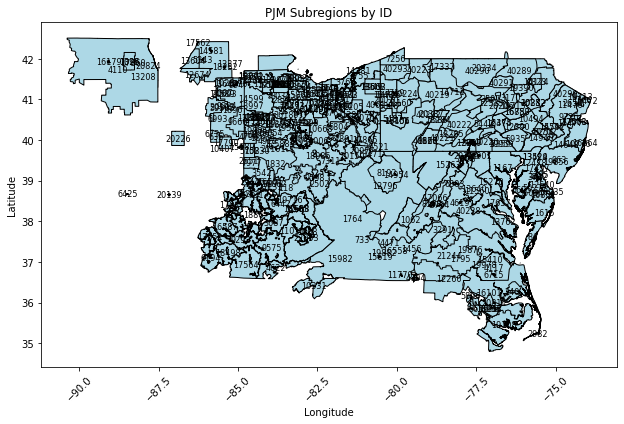

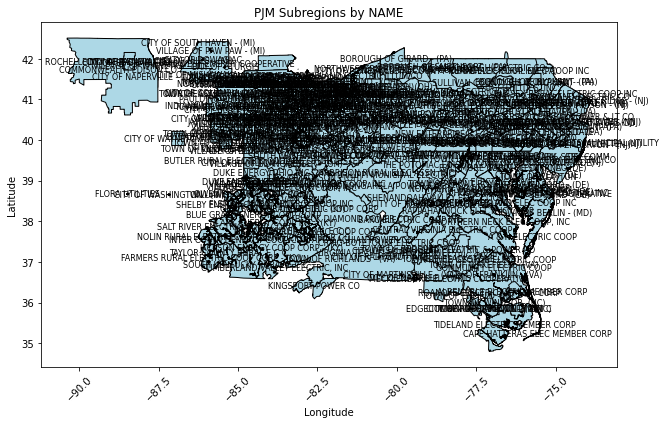

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
# Function to plot subregions annotated by a specific column
def plot_subregions_with_annotations(gdf, annotation_column, title):
    fig, ax = plt.subplots(figsize=(12, 6))
    gdf.plot(ax=ax, color='lightblue', edgecolor='black')
    
    # Annotate each subregion
    for idx, row in gdf.iterrows():
        centroid = row.geometry.centroid
        ax.text(centroid.x, centroid.y, row[annotation_column], fontsize=8, ha='center', va='center')
    
    ax.set_title(title)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot PJM subregions annotated by 'ID'
plot_subregions_with_annotations(pjm_subregions, 'ID', 'PJM Subregions by ID')

# Plot PJM subregions annotated by 'NAME'
plot_subregions_with_annotations(pjm_subregions, 'NAME', 'PJM Subregions by NAME')


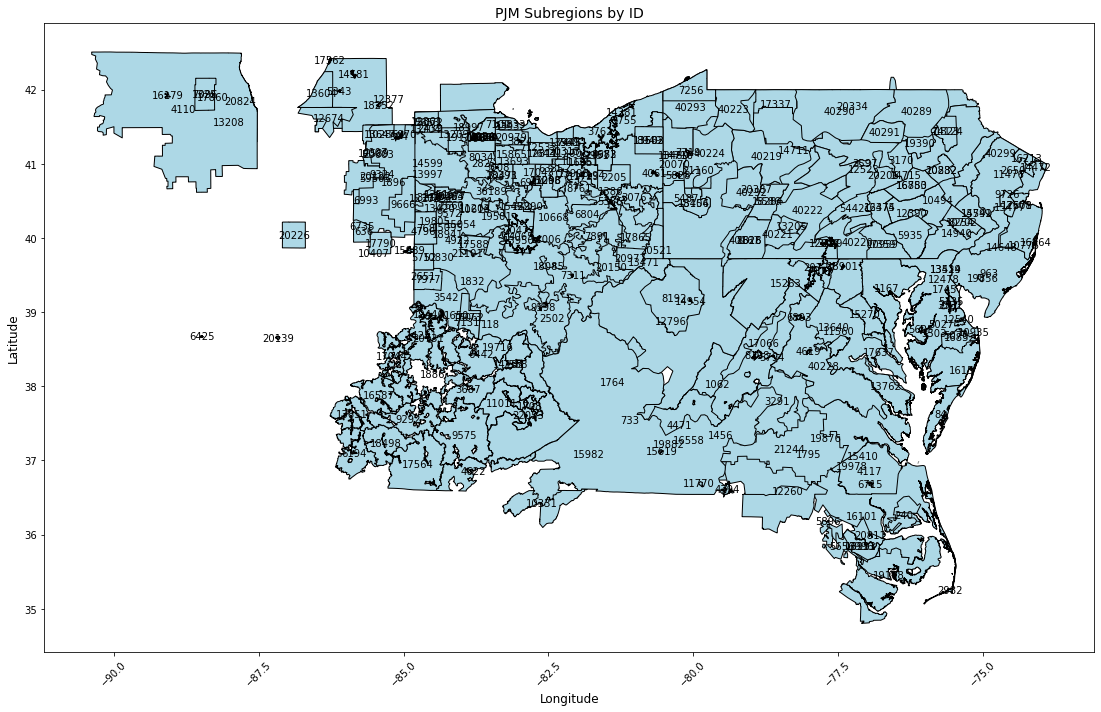

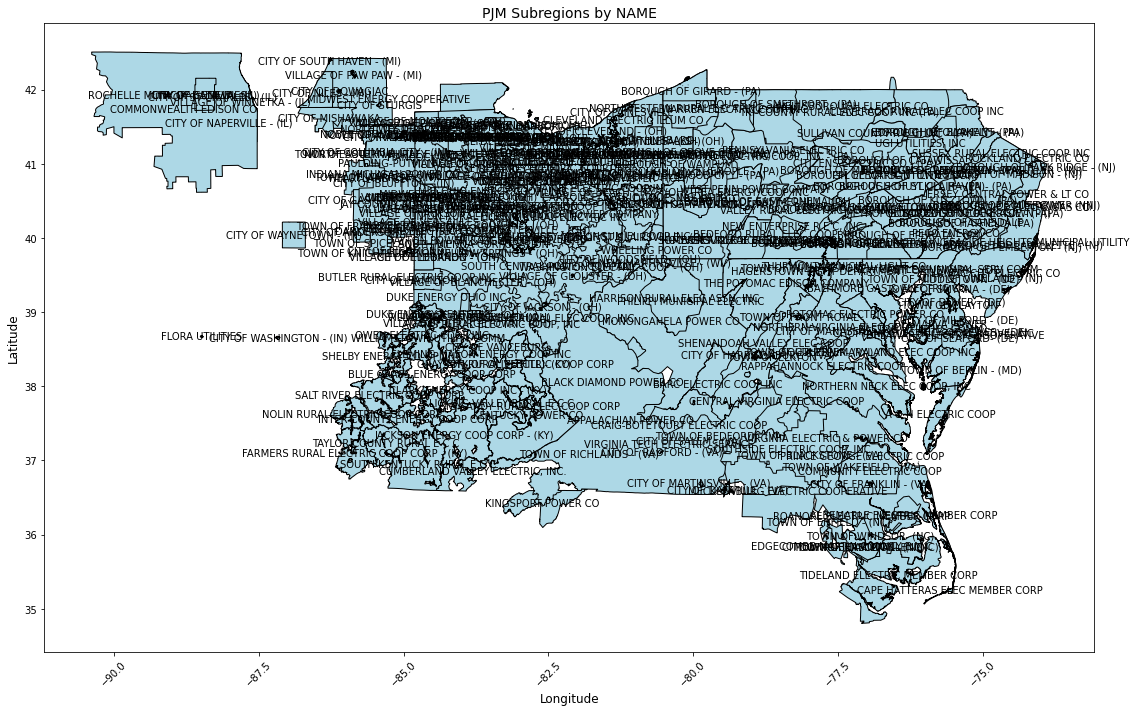

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming pjm_subregions is already defined and filtered
# Function to plot subregions annotated by a specific column
def plot_subregions_with_multiple_annotations(gdf, title):
    fig, ax = plt.subplots(figsize=(18, 10))
    # Assign unique colors based on 'CNTRL_AREA' or another categorizing column for comparison
    gdf['color'] = gdf['CNTRL_AREA'].astype('category').cat.codes  # Example categorization
    gdf.plot(ax=ax, edgecolor='black', column='color', cmap='Set3', legend=True, alpha=0.5)  # Semi-transparent for overlap detection
    
    # Annotate with 'ID' and 'NAME'
    for idx, row in gdf.iterrows():
        centroid = row.geometry.centroid
        # Annotate ID
        ax.text(centroid.x, centroid.y, str(row['ID']), fontsize=8, ha='center', va='center', color='blue')
        # Annotate NAME slightly offset for visibility
        ax.text(centroid.x, centroid.y + 0.02, row['NAME'], fontsize=8, ha='center', va='center', color='red')
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

# Assuming pjm_subregions GeoDataFrame is already filtered for 'PJM INTERCONNECTION, LLC'
# Plot PJM subregions annotated by 'ID'
plot_subregions_with_annotations(pjm_subregions, 'ID', 'PJM Subregions by ID')

# Plot PJM subregions annotated by 'NAME'
plot_subregions_with_annotations(pjm_subregions, 'NAME', 'PJM Subregions by NAME')


In [12]:
import pandas as pd

# Assuming 'ba_subregions' is your GeoDataFrame and it includes a 'NAME' column
# Find duplicate names
duplicate_names = ba_subregions[ba_subregions.duplicated('NAME', keep=False)]

# Sort based on name to make review easier
duplicate_names_sorted = duplicate_names.sort_values('NAME')

# Check if there are any duplicate names
if not duplicate_names_sorted.empty:
    print("Overlapping names detected:")
    print(duplicate_names_sorted[['NAME', 'geometry']])
else:
    print("No overlapping names detected.")


Overlapping names detected:
                              NAME  \
2672                  CITY OF HOPE   
2867                  CITY OF HOPE   
2343   LATHROP IRRIGATION DISTRICT   
2800   LATHROP IRRIGATION DISTRICT   
571   NORTH CENTRAL ELEC COOP, INC   
572   NORTH CENTRAL ELEC COOP, INC   
1938               TOWN OF CLAYTON   
1939               TOWN OF CLAYTON   

                                               geometry  
2672  POLYGON ((-93.82312 34.00873, -93.82307 34.008...  
2867  MULTIPOLYGON (((-93.58308 33.63176, -93.57966 ...  
2343  POLYGON ((-121.02728 38.30008, -121.00697 38.2...  
2800  POLYGON ((-121.41150 37.80349, -121.41008 37.8...  
571   POLYGON ((-83.44439 41.21782, -83.43286 41.234...  
572   POLYGON ((-101.85633 48.78643, -101.84869 48.8...  
1938  MULTIPOLYGON (((-78.70827 35.51934, -78.69862 ...  
1939  POLYGON ((-75.48136 39.38754, -75.47118 39.375...  


In [14]:
import geopandas as gpd

# Assuming ba_subregions is your GeoDataFrame

# Create a spatial index
sindex = ba_subregions.sindex

# List to hold records of overlaps
overlaps = []

# Iterate over each geometry in the GeoDataFrame
for idx, geometry in enumerate(ba_subregions.geometry):
    # Potential matches index
    possible_matches_index = list(sindex.intersection(geometry.bounds))
    # Potential matches are actually retrieved using iloc
    possible_matches = ba_subregions.iloc[possible_matches_index]
    # Filter out the potential matches to get actual overlaps
    precise_matches = possible_matches[possible_matches.intersects(geometry)]
    # Exclude the geometry itself from the results
    precise_matches = precise_matches[precise_matches.index != idx]
    
    if not precise_matches.empty:
        overlaps.append((idx, list(precise_matches.index)))

# Print the results
for idx, overlapping_idxs in overlaps:
    print(f"Geometry at index {idx} overlaps with geometries at indexes {overlapping_idxs}")



Geometry at index 0 overlaps with geometries at indexes [2582, 1634, 2332]
Geometry at index 1 overlaps with geometries at indexes [2, 1694, 1043, 2357, 840, 1093, 915, 2439, 667, 224, 1690, 674, 816, 678, 1038, 1741, 242, 2434, 394, 2716, 2906, 5]
Geometry at index 2 overlaps with geometries at indexes [866, 642, 2506, 583, 1442, 4, 2059, 913, 1692, 540, 1128, 2868, 2036, 1903, 1605, 1397, 690, 1533, 1344, 877, 446, 498, 466, 384, 156, 197, 2528, 2607, 2467, 1271, 1813, 547, 2287, 2407, 2302, 1050, 2925, 2788, 453, 1756, 1694, 1043, 1047, 433, 67, 2254, 1334, 2727, 2598, 1577, 2357, 1235, 1984, 1744, 840, 1093, 915, 2439, 270, 2640, 667, 323, 450, 2431, 224, 1, 1690, 816, 168, 1038, 1741, 2661, 2360, 369, 2624, 2107, 2278, 1884, 1567, 394, 958, 1711]
Geometry at index 3 overlaps with geometries at indexes [608, 1871, 1011, 329, 1449, 2743, 1139, 2093, 2937, 2546, 1652, 1847, 1082, 447, 2563, 2667, 1469, 2834, 2353, 284, 2325, 1015, 1328, 744, 926, 1872]
Geometry at index 4 overlaps wi

In [5]:
import netCDF4 as nc

# Path to your .nc file
nc_file_path = '/Users/ansonkong/Downloads/tgw_wrf_rcp85hotter_hourly_2060-01-01_01_00_00.nc'

# Open the NetCDF file
ds = nc.Dataset(nc_file_path, 'r')  # 'r' is for read mode

# Explore the structure
print('Global attributes:')
print(ds.ncattrs())  # Print global attributes

print('\nVariables:')
for var in ds.variables:
    print(var)  # Print variable name and details
print('==================next') 
print('\nDimensions:')
for dim in ds.dimensions:
    print(dim)  # Print dimension name and details
# Example: Counting observations for a variable that spans time, latitude, and longitude
if 'Time' in ds.dimensions and 'west_east' in ds.dimensions and 'west_east' in ds.dimensions:
    num_observations = ds.dimensions['Time'].size * ds.dimensions['west_east'].size * ds.dimensions['west_east'].size
    print(f"Total observations: {num_observations}")
else:
    print("Required dimensions not found in the dataset.")
# Close the Dataset when done
ds.close()


Global attributes:
['TITLE', 'START_DATE', 'SIMULATION_START_DATE', 'WEST-EAST_GRID_DIMENSION', 'SOUTH-NORTH_GRID_DIMENSION', 'BOTTOM-TOP_GRID_DIMENSION', 'DX', 'DY', 'AERCU_OPT', 'AERCU_FCT', 'IDEAL_CASE', 'DIFF_6TH_SLOPEOPT', 'AUTO_LEVELS_OPT', 'DIFF_6TH_THRESH', 'DZBOT', 'DZSTRETCH_S', 'DZSTRETCH_U', 'SKEBS_ON', 'SPEC_BDY_FINAL_MU', 'USE_Q_DIABATIC', 'GRIDTYPE', 'DIFF_OPT', 'KM_OPT', 'DAMP_OPT', 'DAMPCOEF', 'KHDIF', 'KVDIF', 'MP_PHYSICS', 'RA_LW_PHYSICS', 'RA_SW_PHYSICS', 'SF_SFCLAY_PHYSICS', 'SF_SURFACE_PHYSICS', 'BL_PBL_PHYSICS', 'CU_PHYSICS', 'SF_LAKE_PHYSICS', 'SURFACE_INPUT_SOURCE', 'SST_UPDATE', 'GRID_FDDA', 'GFDDA_INTERVAL_M', 'GFDDA_END_H', 'GRID_SFDDA', 'SGFDDA_INTERVAL_M', 'SGFDDA_END_H', 'HYPSOMETRIC_OPT', 'USE_THETA_M', 'GWD_OPT', 'SF_URBAN_PHYSICS', 'SF_SURFACE_MOSAIC', 'SF_OCEAN_PHYSICS', 'SHCU_PHYSICS', 'MFSHCONV', 'FEEDBACK', 'SMOOTH_OPTION', 'SWRAD_SCAT', 'W_DAMPING', 'ADAPT_DT_START', 'ADAPT_DT_MAX', 'ADAPT_DT_MIN', 'RADT', 'BLDT', 'CUDT', 'AER_OPT', 'SWINT_OPT', '

In [16]:
import geopandas as gpd
import netCDF4 as nc
import numpy as np
import rasterio
from rasterio.features import geometry_mask

# Load the shapefile
shapefile_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/Electric_Retail_Service_Territories.shp'
ba_subregions = gpd.read_file(shapefile_path)

# Open the NetCDF file
nc_file_path ='/Users/ansonkong/Downloads/tgw_wrf_rcp85hotter_hourly_2060-01-01_01_00_00.nc'
ds = nc.Dataset(nc_file_path, 'r')
# Assuming latitude and longitude variables are named 'lat' and 'lon' in the NetCDF file
latitudes = ds.variables['lat'][:]
longitudes = ds.variables['lon'][:]

# Assuming the NetCDF data is structured such that we have a 2D grid of latitudes and longitudes
# Create a grid of coordinates (this assumes a simple grid; adjustments may be needed for complex grids)
lon, lat = np.meshgrid(longitudes, latitudes)

# Flatten the grid arrays and pair them up as coordinates
coordinates = np.dstack([lon.flatten(), lat.flatten()])[0]
time_step = 0  # Adjust as necessary
variables = ['T2', 'Q2', 'SWDOWN', 'GLW', 'WSPD']  # Example variables

# Dictionary to hold extracted data
nc_data = {var: ds.variables[var][time_step, :, :] for var in variables}


In [1]:
import pandas as pd
import geopandas as gpd
import netCDF4 as nc
from shapely.geometry import Point
import numpy as np

# Load the shapefile and ensure it's in WGS 84 CRS
shapefile_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/Electric_Retail_Service_Territories.shp'
ba_subregions = gpd.read_file(shapefile_path).to_crs(epsg=4326)

# Open the NetCDF file
nc_file_path = '/Users/ansonkong/Downloads/tgw_wrf_rcp85hotter_hourly_2060-01-01_01_00_00.nc'
ds = nc.Dataset(nc_file_path, 'r')


# Accessing the 'Times' variable
times_array = ds.variables['Times'][:]  # Access the 'Times' variable

# Since 'Times' variable is stored as byte strings, decode each byte string to a regular string
times_str_list = [b''.join(times_array[t]).decode('ascii') for t in range(times_array.shape[0])]

# Convert the list of datetime strings to pandas datetime objects
times = pd.to_datetime(times_str_list, format='%Y-%m-%d_%H:%M:%S')

# Preparing the DataFrame to store results
columns = ['CNTRL_AREA', 'Time', 'T2_mean', 'Q2_mean', 'SWDOWN_mean', 'GLW_mean', 'WSPD_mean']
results_df = pd.DataFrame(columns=columns)

# Process each time step
for t_idx, time in enumerate(times):
    print(f"Processing time step: {t_idx+1}/{len(times)} at {time}")
    
    # Dynamically access latitude and longitude for the current time step
    lats = ds.variables['XLAT'][t_idx, :, :]
    lons = ds.variables['XLONG'][t_idx, :, :]
    
    temp_data = {
        'geometry': [Point(lon, lat) for lat, lon in zip(np.ravel(lats), np.ravel(lons))],
    }
    
    # Extract variable data for the current time step
    for var in ['T2', 'Q2', 'SWDOWN', 'GLW', 'WSPD']:
        temp_data[var] = np.ravel(ds.variables[var][t_idx, :, :])
    
    # Create a GeoDataFrame for the current time step
    gdf_points = gpd.GeoDataFrame(temp_data, geometry='geometry', crs='EPSG:4326')

    # Perform spatial join with the shapefile regions, ensuring proper use of the 'predicate' parameter
    joined = gpd.sjoin(gdf_points, ba_subregions, how='left', predicate='intersects')

    # Ensure numeric data types for aggregation, and exclude 'geometry' column
    for col in ['T2', 'Q2', 'SWDOWN', 'GLW', 'WSPD']:
        if not pd.api.types.is_numeric_dtype(joined[col]):
            print(f"Column '{col}' is not numeric. Examples:\n{joined[col].head()}")
            # Attempt to convert to numeric, errors='coerce' will convert non-numeric to NaN
            joined[col] = pd.to_numeric(joined[col], errors='coerce')
    
    # Aggregating numeric data by 'CNTRL_AREA' using mean, handling non-numeric gracefully
    agg_data = joined.groupby('CNTRL_AREA')[['T2', 'Q2', 'SWDOWN', 'GLW', 'WSPD']].mean().reset_index()
    agg_data['Time'] = time  # Append the time information
    # Print the total number of rows in agg_data
    print(f"Total number of rows: {agg_data.shape[0]}")

    # Print the number of NaN values for each column in agg_data
    for col in agg_data.columns:
        num_nans = agg_data[col].isna().sum()
        print(f"Number of NaNs in '{col}': {num_nans}")
    results_df = pd.concat([results_df, agg_data], ignore_index=True)

# Save the aggregated results
results_file_path = '/Users/ansonkong/Downloads/aggregated_data_with_time.csv'
results_df.to_csv(results_file_path, index=False)
print(f"Data aggregation complete. Check '{results_file_path}'")

# Closing the dataset
ds.close()



/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


Processing time step: 1/168 at 2060-01-01 01:00:00
Total number of rows: 59
Number of NaNs in 'CNTRL_AREA': 0
Number of NaNs in 'T2': 0
Number of NaNs in 'Q2': 0
Number of NaNs in 'SWDOWN': 0
Number of NaNs in 'GLW': 0
Number of NaNs in 'WSPD': 0
Number of NaNs in 'Time': 0
Processing time step: 2/168 at 2060-01-01 02:00:00


/var/folders/8v/68yqll_54lzgb57b5q8_fbrc0000gn/T/ipykernel_2625/625538290.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, agg_data], ignore_index=True)


Total number of rows: 59
Number of NaNs in 'CNTRL_AREA': 0
Number of NaNs in 'T2': 0
Number of NaNs in 'Q2': 0
Number of NaNs in 'SWDOWN': 0
Number of NaNs in 'GLW': 0
Number of NaNs in 'WSPD': 0
Number of NaNs in 'Time': 0
Processing time step: 3/168 at 2060-01-01 03:00:00
Total number of rows: 59
Number of NaNs in 'CNTRL_AREA': 0
Number of NaNs in 'T2': 0
Number of NaNs in 'Q2': 0
Number of NaNs in 'SWDOWN': 0
Number of NaNs in 'GLW': 0
Number of NaNs in 'WSPD': 0
Number of NaNs in 'Time': 0
Processing time step: 4/168 at 2060-01-01 04:00:00
Total number of rows: 59
Number of NaNs in 'CNTRL_AREA': 0
Number of NaNs in 'T2': 0
Number of NaNs in 'Q2': 0
Number of NaNs in 'SWDOWN': 0
Number of NaNs in 'GLW': 0
Number of NaNs in 'WSPD': 0
Number of NaNs in 'Time': 0
Processing time step: 5/168 at 2060-01-01 05:00:00
Total number of rows: 59
Number of NaNs in 'CNTRL_AREA': 0
Number of NaNs in 'T2': 0
Number of NaNs in 'Q2': 0
Number of NaNs in 'SWDOWN': 0
Number of NaNs in 'GLW': 0
Number 

OSError: Cannot save file into a non-existent directory: '/path/to'

In [40]:
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy.interpolate import interp1d
import netCDF4 as nc
from shapely.geometry import Point
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
# Define paths
shapefile_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/Electric_Retail_Service_Territories.shp'
county_shapefile_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/Electric_Retail_Service_Territories.shp'
population_data_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/ssp3_county_population.csv'
nc_file_path = '/Users/ansonkong/Downloads/tgw_wrf_rcp85hotter_hourly_2060-01-01_01_00_00.nc'

# Load data
print("Loading geographical data...")
# Load geographical data

ba_subregions = gpd.read_file(shapefile_path).to_crs(epsg=3857)
counties = gpd.read_file(county_shapefile_path).to_crs(epsg=3857) 
counties = counties.rename(columns={'ID': 'FIPS'})
# Check if 'CNTRL_AREA' needs adjustment (debugging)
#print("Control Areas:", ba_subregions['CNTRL_AREA'].unique())
print(f"Loaded {len(ba_subregions)} subregions and {len(counties)} counties.")

print("Loading and preparing population data...")
# Load and prepare population data
population_data = pd.read_csv(population_data_path)
print(f"Loaded population data for {len(population_data)} records.")
# Interpolation for population data
print("Interpolating population data...")
# Ensure FIPS codes are properly formatted (debugging)
#print("Population data FIPS unique values:", population_data['FIPS'].unique()[:5])
# Define years for interpolation
years = np.arange(2020, 2101, 10)  # Known population data years
interp_years = np.arange(2020, 2101)  # Target years for interpolation

# Perform interpolation for each FIPS code
for index, row in population_data.iterrows():
    fips = row['FIPS']
    pop_values = row[years.astype(str)].values
    interpolator = interp1d(years, pop_values, kind='linear', fill_value="extrapolate")
    interpolated_values = interpolator(interp_years)
    population_data.loc[index, interp_years.astype(str)] = interpolated_values

print("Population data interpolation complete.")

print("Opening NetCDF file...")
# Open NetCDF file
ds = nc.Dataset(nc_file_path, 'r')

# Accessing and cleaning the 'Times' variable
print("Processing time variable...")
times_array = ds.variables['Times'][:]  # Assuming 'Times' is the time variable
times_str_list = [b''.join(times_array[t]).decode('ascii') for t in range(times_array.shape[0])]
times = pd.to_datetime(times_str_list, format='%Y-%m-%d_%H:%M:%S')

print(f"Found {len(times)} time steps.")


year_of_interest = str(times[0].year) 
# Prepare NetCDF data points
# Preparing NetCDF data points
print("Preparing NetCDF data points...")
lats = ds.variables['XLAT'][0, :, :]
lons = ds.variables['XLONG'][0, :, :]
print(f"Latitude shape: {lats.shape}, Longitude shape: {lons.shape}")


variables = ['T2', 'Q2', 'SWDOWN', 'GLW', 'WSPD']  # Assuming these are the variables you're interested in
print(ds.variables['XLAT'].shape)
print(ds.variables['XLONG'].shape)
for var in variables:
    print(var, ds.variables[var].shape)
data_points=[]
# Create a DataFrame for NetCDF data points with environmental variables
# Assuming 'variables' contains the names of the environmental variables you're interested in
# Extract data for each variable and create a list of dictionaries for each point
# Corrected loop to access data for a single time step
time_step = 0  # Selecting the first time step

# Select the time slice for latitude and longitude arrays
lat_slice = lats
lon_slice = lons
total_time_steps = len(times_array)
total_lat_points = lat_slice.shape[0]
total_lon_points = lon_slice.shape[1]
total_iterations = total_time_steps * total_lat_points * total_lon_points

#print(f"Starting processing at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total iterations: {total_iterations}")

# Initialize a counter to track progress
iteration_counter = 0
# Prepare data_points list for GeoDataFrame
data_points = []


for time_step, time_value in enumerate(times[:1]):
#for time_step, time_value in enumerate(times):
#Limit number of time run
    for i in range(total_lat_points):
        for j in range(total_lon_points):
            lat = ds.variables['XLAT'][time_step, i, j]
            lon = ds.variables['XLONG'][time_step, i, j]
            point_data = {
                'Time': time_value,
                'Latitude': lat,
                'Longitude': lon,
                'geometry': Point(lon, lat)
            }
            for var in variables:
                point_data[var] = ds.variables[var][time_step, i, j]
            data_points.append(point_data)
            
            # Update the iteration counter
            iteration_counter += 1
            
            # Print progress for every 1% completed
            if iteration_counter % (total_iterations // 100) == 0:
                percent_done = (iteration_counter / total_iterations) * 100
                print(f"Progress: {percent_done:.2f}% completed.")

# Convert to GeoDataFrame

gdf_points = gpd.GeoDataFrame(data_points, crs='EPSG:3857')
print("Processing completed.")

# Assuming gdf_points and counties are already defined
gdf_points_with_county = gpd.sjoin(gdf_points, counties[['geometry', 'FIPS']], how='left', op='intersects')
# Drop or rename 'index_left' and 'index_right' if they exist
if 'index_left' in gdf_points_with_county.columns:
    gdf_points_with_county.drop(columns=['index_left'], inplace=True)
if 'index_right' in gdf_points_with_county.columns:
    gdf_points_with_county.drop(columns=['index_right'], inplace=True)
gdf_points_with_county = gpd.sjoin(gdf_points_with_county, ba_subregions[['geometry', 'CNTRL_AREA']], how='left', op='intersects')

print("Processing spatial join.")
print("After spatial join:", gdf_points_with_county.head())
print(gdf_points_with_county[gdf_points_with_county['FIPS'].isna()])

# Convert FIPS to string and zfill to ensure 5 digits
gdf_points_with_county['FIPS'] = gdf_points_with_county['FIPS'].astype(str).str.zfill(5)
print("Processing  Group by 'FIPS' and 'Time', then average the variables.")
# Group by 'FIPS' and 'Time', then average the variables
# Specify the columns to aggregate and how to aggregate them
aggregations = {col: 'mean' for col in gdf_points_with_county.columns if col not in ['FIPS', 'Time', 'geometry']}
# Include any specific aggregations for non-numeric columns if necessary, for example:
# aggregations['SomeCategoricalColumn'] = lambda x: scipy.stats.mode(x)[0]

grouped = gdf_points_with_county.groupby(['FIPS', 'Time']).agg(aggregations).reset_index()

# Determine the majority CNTRL_AREA for each FIPS and Time
# Assuming 'CNTRL_AREA' is a column in gdf_points_with_county
# For example, using 'mode' to find the most frequent 'CNTRL_AREA' value for each 'FIPS' code.
# Here, we're using 'value_counts' to find the most common 'CNTRL_AREA' for each 'FIPS' code
majority_cntrl_area = gdf_points_with_county.groupby('FIPS')['CNTRL_AREA'].agg(lambda x: x.value_counts().index[0] if not x.empty else np.nan).reset_index()

# Now, you can safely merge this information with the 'counties' GeoDataFrame for plotting
counties_with_majority_area = counties.merge(majority_cntrl_area, on='FIPS')

# Ensure the merged DataFrame is ready for plotting
counties_with_majority_area = counties_with_majority_area.to_crs(epsg=3857)  # For contextily basemap compatibility

# Ensure population data's FIPS codes are strings and zero-filled to 5 digits
population_data['FIPS'] = population_data['FIPS'].astype(str).str.zfill(5)

# Merge grouped data with population data
grouped_with_pop = grouped.merge(population_data, on='FIPS', how='left')
# Define a function for weighted average
def weighted_avg(group, variables):
    weights = group['population']
    return {var: np.average(group[var], weights=weights) for var in variables}

# Apply weighted average for each variable within each CNTRL_AREA
weighted_averages = grouped_with_pop.groupby('CNTRL_AREA').apply(lambda x: weighted_avg(x, variables)).reset_index()

# Convert the result into a DataFrame if necessary
weighted_averages_df = pd.DataFrame(list(weighted_averages[0]), index=weighted_averages['CNTRL_AREA']).reset_index()
# Save the aggregated results
results_file_path = '/Users/ansonkong/Downloads/weighted_aggregated_data_with_time.csv'
weighted_averages_df.to_csv(results_file_path, index=False)
print(f"Data aggregation complete. Check '{results_file_path}'")
# Close the NetCDF dataset
ds.close()





Loading geographical data...
Loaded 2949 subregions and 2949 counties.
Loading and preparing population data...
Loaded population data for 3108 records.
Interpolating population data...
Population data interpolation complete.
Opening NetCDF file...
Processing time variable...
Found 168 time steps.
Preparing NetCDF data points...
Latitude shape: (299, 424), Longitude shape: (299, 424)
(168, 299, 424)
(168, 299, 424)
T2 (168, 299, 424)
Q2 (168, 299, 424)
SWDOWN (168, 299, 424)
GLW (168, 299, 424)
WSPD (168, 299, 424)
Total iterations: 21298368
Processing completed.


/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Processing spatial join.
After spatial join:                  Time   Latitude    Longitude                 geometry  \
0 2060-01-01 01:00:00   21.04686   -120.97156  POINT (-120.972 21.047)   
1 2060-01-01 01:00:00  21.073246   -120.86305  POINT (-120.863 21.073)   
2 2060-01-01 01:00:00  21.099514  -120.754486  POINT (-120.754 21.100)   
3 2060-01-01 01:00:00  21.125668   -120.64584  POINT (-120.646 21.126)   
4 2060-01-01 01:00:00  21.151703   -120.53714  POINT (-120.537 21.152)   

          T2           Q2    SWDOWN        GLW       WSPD FIPS  index_right  \
0   296.8221  0.015045315  94.54849     349.63   7.688218  NaN          NaN   
1  296.81345  0.015027003  92.85902   349.3631  7.6723022  NaN          NaN   
2  296.80435  0.015008815  91.17697    349.099  7.6333475  NaN          NaN   
3  296.79492  0.014989832  89.51024   348.7426   7.617999  NaN          NaN   
4   296.7806   0.01497129  87.84994  348.35385  7.6193123  NaN          NaN   

  CNTRL_AREA  
0        NaN  
1    

IndexError: index 0 is out of bounds for axis 0 with size 0

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


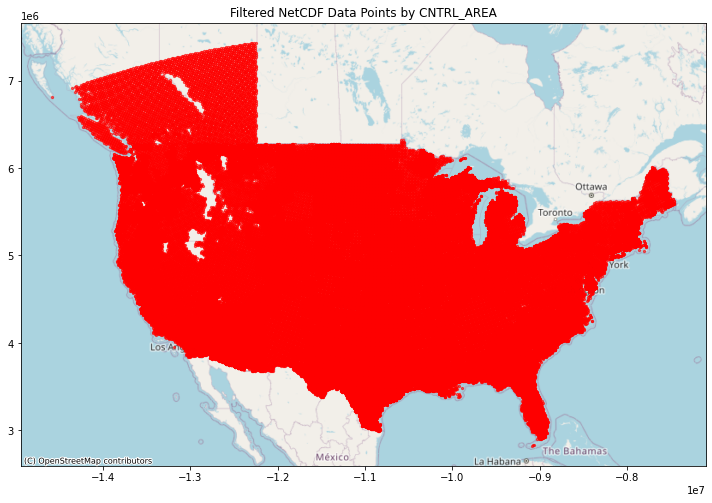

In [8]:
import geopandas as gpd
import netCDF4 as nc
import numpy as np
from shapely.geometry import Point
import contextily as ctx
import matplotlib.pyplot as plt

# Step 1: Load and Prepare Geographic Data
# Load shapefile and filter for non-NaN 'CNTRL_AREA'
# Define paths
shapefile_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/Electric_Retail_Service_Territories.shp'
county_shapefile_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/Electric_Retail_Service_Territories.shp'
population_data_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/ssp3_county_population.csv'
nc_file_path = '/Users/ansonkong/Downloads/tgw_wrf_rcp85hotter_hourly_2060-01-01_01_00_00.nc'
ba_subregions = gpd.read_file(shapefile_path)
ba_subregions = ba_subregions[ba_subregions['CNTRL_AREA'].notna()].to_crs(epsg=4326)

# Load NetCDF file

ds = nc.Dataset(nc_file_path, 'r')

# Step 2: Extract Data Points from NetCDF
time_step = 0  # Example: first time step
lats = ds.variables['XLAT'][time_step, :, :]
lons = ds.variables['XLONG'][time_step, :, :]

# Create GeoDataFrame for NetCDF data points
gdf_points = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in zip(np.ravel(lats), np.ravel(lons))], crs='EPSG:4326')

# Step 3: Perform Spatial Join
# Perform spatial join to filter points based on 'CNTRL_AREA'
gdf_points_filtered = gpd.sjoin(gdf_points, ba_subregions, how='inner', op='intersects')

# Step 4: Plotting
# Transform to Web Mercator CRS for contextily basemap compatibility
gdf_points_filtered = gdf_points_filtered.to_crs(epsg=3857)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
gdf_points_filtered.plot(ax=ax, color='red', markersize=5, alpha=0.6)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set title and adjust plot
ax.set_title('Filtered NetCDF Data Points by CNTRL_AREA')
plt.tight_layout()
plt.show()

# Step 5: Cleanup
# Close the NetCDF dataset after processing
ds.close()


In [43]:
print(gdf_points_with_county.crs)
print(ba_subregions.crs)


EPSG:3857
EPSG:3857


Loading geographical data...
Loaded 2949 subregions and 2949 counties.
Loading and preparing population data...
Loaded population data for 3108 records.
Interpolating population data...
Population data interpolation complete.
Opening NetCDF file...
Processing time variable...
Found 168 time steps.
Preparing NetCDF data points...
Latitude shape: (299, 424), Longitude shape: (299, 424)
(168, 299, 424)
(168, 299, 424)
T2 (168, 299, 424)
Q2 (168, 299, 424)
SWDOWN (168, 299, 424)
GLW (168, 299, 424)
WSPD (168, 299, 424)
Total iterations: 21298368
Processing completed.


/var/folders/8v/68yqll_54lzgb57b5q8_fbrc0000gn/T/ipykernel_43178/2926973805.py:135: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  gdf_points.plot(ax=ax, color='blue', column='CNTRL_AREA',markersize=5, alpha=0.5, label='NetCDF Data Points')
/opt/anaconda3/lib/python3.9/site-packages/contextily/tile.py:620: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


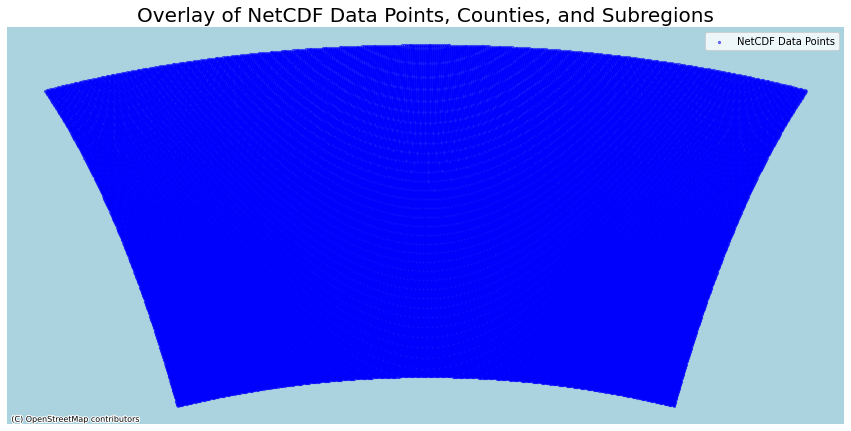

Index(['OBJECTID', 'FIPS', 'NAME', 'ADDRESS', 'CITY', 'STATE', 'ZIP',
       'TELEPHONE', 'TYPE', 'COUNTRY', 'NAICS_CODE', 'NAICS_DESC', 'SOURCE',
       'SOURCEDATE', 'VAL_METHOD', 'VAL_DATE', 'WEBSITE', 'REGULATED',
       'CNTRL_AREA', 'PLAN_AREA', 'HOLDING_CO', 'SUMMR_PEAK', 'WINTR_PEAK',
       'SUMMER_CAP', 'WINTER_CAP', 'NET_GEN', 'PURCHASED', 'NET_EX',
       'RETAIL_MWH', 'WSALE_MWH', 'TOTAL_MWH', 'TRANS_MWH', 'CUSTOMERS',
       'YEAR', 'Shape__Are', 'Shape__Len', 'geometry'],
      dtype='object')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


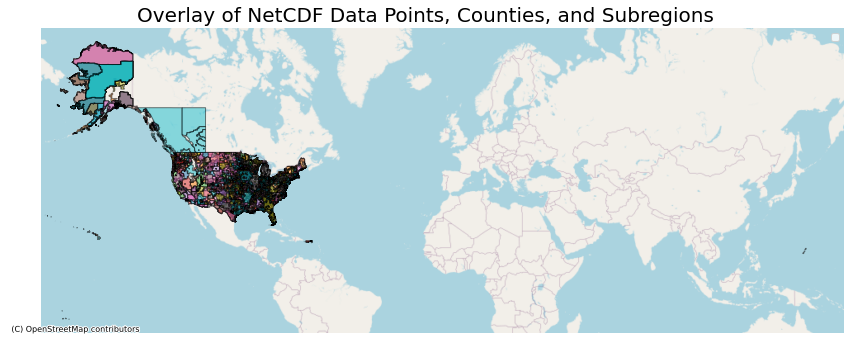

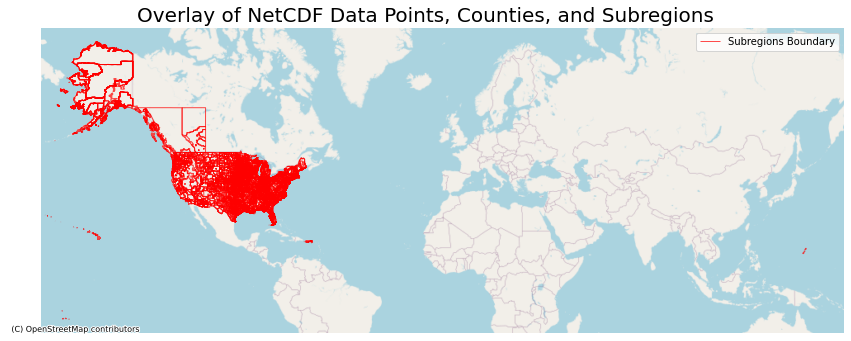

In [4]:
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy.interpolate import interp1d
import netCDF4 as nc
from shapely.geometry import Point
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
# Define paths
shapefile_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/Electric_Retail_Service_Territories.shp'
county_shapefile_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/Electric_Retail_Service_Territories.shp'
population_data_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/ssp3_county_population.csv'
nc_file_path = '/Users/ansonkong/Downloads/tgw_wrf_rcp85hotter_hourly_2060-01-01_01_00_00.nc'

# Load data
print("Loading geographical data...")
# Load geographical data

ba_subregions = gpd.read_file(shapefile_path).to_crs(epsg=3857)
counties = gpd.read_file(county_shapefile_path).to_crs(epsg=3857) 
counties = counties.rename(columns={'ID': 'FIPS'})
# Check if 'CNTRL_AREA' needs adjustment (debugging)
#print("Control Areas:", ba_subregions['CNTRL_AREA'].unique())
print(f"Loaded {len(ba_subregions)} subregions and {len(counties)} counties.")

print("Loading and preparing population data...")
# Load and prepare population data
population_data = pd.read_csv(population_data_path)
print(f"Loaded population data for {len(population_data)} records.")
# Interpolation for population data
print("Interpolating population data...")
# Ensure FIPS codes are properly formatted (debugging)
#print("Population data FIPS unique values:", population_data['FIPS'].unique()[:5])
# Define years for interpolation
years = np.arange(2020, 2101, 10)  # Known population data years
interp_years = np.arange(2020, 2101)  # Target years for interpolation

# Perform interpolation for each FIPS code
for index, row in population_data.iterrows():
    fips = row['FIPS']
    pop_values = row[years.astype(str)].values
    interpolator = interp1d(years, pop_values, kind='linear', fill_value="extrapolate")
    interpolated_values = interpolator(interp_years)
    population_data.loc[index, interp_years.astype(str)] = interpolated_values

print("Population data interpolation complete.")

print("Opening NetCDF file...")
# Open NetCDF file
ds = nc.Dataset(nc_file_path, 'r')

# Accessing and cleaning the 'Times' variable
print("Processing time variable...")
times_array = ds.variables['Times'][:]  # Assuming 'Times' is the time variable
times_str_list = [b''.join(times_array[t]).decode('ascii') for t in range(times_array.shape[0])]
times = pd.to_datetime(times_str_list, format='%Y-%m-%d_%H:%M:%S')

print(f"Found {len(times)} time steps.")


year_of_interest = str(times[0].year) 
# Prepare NetCDF data points
# Preparing NetCDF data points
print("Preparing NetCDF data points...")
lats = ds.variables['XLAT'][0, :, :]
lons = ds.variables['XLONG'][0, :, :]
print(f"Latitude shape: {lats.shape}, Longitude shape: {lons.shape}")


variables = ['T2', 'Q2', 'SWDOWN', 'GLW', 'WSPD']  # Assuming these are the variables you're interested in
print(ds.variables['XLAT'].shape)
print(ds.variables['XLONG'].shape)
for var in variables:
    print(var, ds.variables[var].shape)
data_points=[]
# Create a DataFrame for NetCDF data points with environmental variables
# Assuming 'variables' contains the names of the environmental variables you're interested in
# Extract data for each variable and create a list of dictionaries for each point
# Corrected loop to access data for a single time step
time_step = 0  # Selecting the first time step

# Select the time slice for latitude and longitude arrays
lat_slice = lats
lon_slice = lons
total_time_steps = len(times_array)
total_lat_points = lat_slice.shape[0]
total_lon_points = lon_slice.shape[1]
total_iterations = total_time_steps * total_lat_points * total_lon_points

#print(f"Starting processing at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total iterations: {total_iterations}")

# Initialize a counter to track progress
iteration_counter = 0
# Prepare data_points list for GeoDataFrame
data_points = []


for time_step, time_value in enumerate(times[:1]):
#for time_step, time_value in enumerate(times):
#Limit number of time run
    for i in range(total_lat_points):
        for j in range(total_lon_points):
            lat = ds.variables['XLAT'][time_step, i, j]
            lon = ds.variables['XLONG'][time_step, i, j]
            point_data = {
                'Time': time_value,
                'Latitude': lat,
                'Longitude': lon,
                'geometry': Point(lon, lat)
            }
            for var in variables:
                point_data[var] = ds.variables[var][time_step, i, j]
            data_points.append(point_data)
            
            # Update the iteration counter
            iteration_counter += 1
            
            # Print progress for every 1% completed
            if iteration_counter % (total_iterations // 100) == 0:
                percent_done = (iteration_counter / total_iterations) * 100
                print(f"Progress: {percent_done:.2f}% completed.")

# Convert to GeoDataFrame

gdf_points = gpd.GeoDataFrame(data_points, crs='EPSG:3857')
print("Processing completed.")
# Assuming gdf_points, counties_with_majority_area, and ba_subregions are ready and in EPSG:3857

fig, ax = plt.subplots(figsize=(15, 15))

# Plot points from NetCDF data
gdf_points.plot(ax=ax, color='blue', column='CNTRL_AREA',markersize=5, alpha=0.5, label='NetCDF Data Points')



# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set title and adjust plot
ax.set_title('Overlay of NetCDF Data Points, Counties, and Subregions', fontsize=20)

# Remove axis for a cleaner look
ax.set_axis_off()

# Add legend
ax.legend()

plt.show()



fig, ax = plt.subplots(figsize=(15, 15))



# Plot counties with majority control area
# Note: This assumes counties_with_majority_area is a GeoDataFrame with a 'CNTRL_AREA' column used for coloring
print(counties.columns)
counties.plot(ax=ax, column='FIPS', alpha=0.5, edgecolor='k', legend=True, label='Counties Majority Control Area')


# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set title and adjust plot
ax.set_title('Overlay of NetCDF Data Points, Counties, and Subregions', fontsize=20)

# Remove axis for a cleaner look
ax.set_axis_off()

# Add legend
ax.legend()

plt.show()



fig, ax = plt.subplots(figsize=(15, 15))


# Overlay the boundaries of the subregions
ba_subregions.boundary.plot(ax=ax, color='red', linewidth=1, alpha=0.7, label='Subregions Boundary')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set title and adjust plot
ax.set_title('Overlay of NetCDF Data Points, Counties, and Subregions', fontsize=20)

# Remove axis for a cleaner look
ax.set_axis_off()

# Add legend
ax.legend()

plt.show()


/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


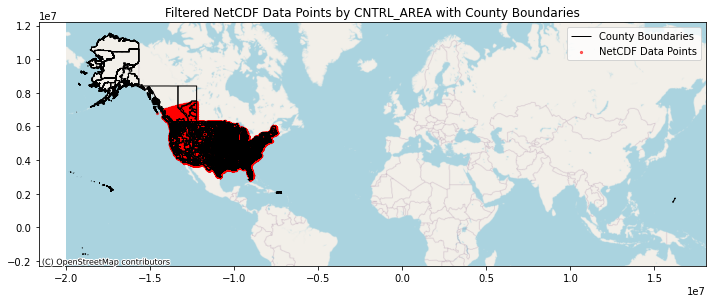

In [10]:
import geopandas as gpd
import netCDF4 as nc
import numpy as np
from shapely.geometry import Point
import contextily as ctx
import matplotlib.pyplot as plt

# Load shapefiles
shapefile_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/Electric_Retail_Service_Territories.shp'
county_shapefile_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/Electric_Retail_Service_Territories.shp'
nc_file_path = '/Users/ansonkong/Downloads/tgw_wrf_rcp85hotter_hourly_2060-01-01_01_00_00.nc'

# Load and prepare geographic data
ba_subregions = gpd.read_file(shapefile_path)
ba_subregions = ba_subregions[ba_subregions['CNTRL_AREA'].notna()].to_crs(epsg=4326)
counties = gpd.read_file(county_shapefile_path).to_crs(epsg=4326)

# Load NetCDF file
ds = nc.Dataset(nc_file_path, 'r')

# Extract data points from NetCDF
time_step = 0  # First time step
lats = ds.variables['XLAT'][time_step, :, :]
lons = ds.variables['XLONG'][time_step, :, :]
gdf_points = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in zip(np.ravel(lats), np.ravel(lons))], crs='EPSG:4326')

# Perform spatial join to filter points based on 'CNTRL_AREA'
gdf_points_filtered = gpd.sjoin(gdf_points, ba_subregions, how='inner', op='intersects')

# Drop 'index_left' and 'index_right' if they exist before performing another spatial join
if 'index_left' in gdf_points_filtered.columns:
    gdf_points_filtered.drop(columns=['index_left'], inplace=True)
if 'index_right' in gdf_points_filtered.columns:
    gdf_points_filtered.drop(columns=['index_right'], inplace=True)

# Perform spatial join to associate points with counties
gdf_points_with_county = gpd.sjoin(gdf_points_filtered, counties, how='left', op='intersects')

# Transform to Web Mercator CRS for contextily basemap compatibility
gdf_points_with_county = gdf_points_with_county.to_crs(epsg=3857)
counties = counties.to_crs(epsg=3857)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot counties
counties.boundary.plot(ax=ax, color='black', linewidth=1, label='County Boundaries')

# Plot filtered NetCDF data points
gdf_points_with_county.plot(ax=ax, color='red', markersize=5, alpha=0.6, label='NetCDF Data Points')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set title and adjust plot
ax.set_title('Filtered NetCDF Data Points by CNTRL_AREA with County Boundaries')
plt.legend()
plt.tight_layout()
plt.show()

# Cleanup
ds.close()



/var/folders/8v/68yqll_54lzgb57b5q8_fbrc0000gn/T/ipykernel_43178/994590884.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  counties_with_majority_cntrl_area['CNTRL_AREA_left'].fillna('No Control Area', inplace=True)


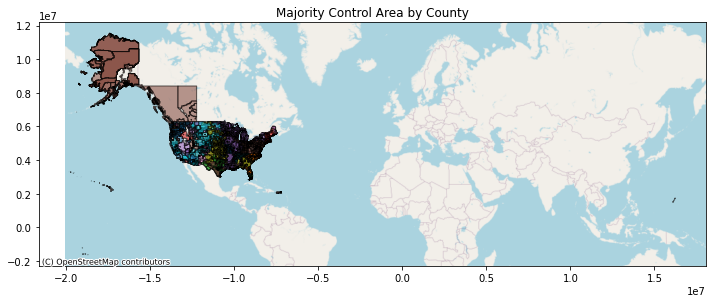

In [16]:
# Ensure 'FIPS' and 'CNTRL_AREA' are in the correct data type for aggregation
gdf_points_with_county['FIPS'] = gdf_points_with_county['ID_left'].astype(str)
counties['FIPS'] = counties['ID'].astype(str)
# Group by 'FIPS' code and determine the most common 'CNTRL_AREA' within each county
majority_cntrl_area_by_county = gdf_points_with_county.groupby('FIPS')['CNTRL_AREA_left'].agg(lambda x: x.mode()[0] if not x.empty else np.nan).reset_index()

# Merge this information back with the counties GeoDataFrame to assign each county its majority control area
counties_with_majority_cntrl_area = counties.merge(majority_cntrl_area_by_county, on='FIPS', how='left')

# Check if any county does not have a control area assigned and fill with a placeholder if necessary
counties_with_majority_cntrl_area['CNTRL_AREA_left'].fillna('No Control Area', inplace=True)

# Plotting to visualize the results
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each county colored by its majority control area
counties_with_majority_cntrl_area.plot(ax=ax, column='CNTRL_AREA_left',  alpha=0.6, edgecolor='black')

# Add basemap for context
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=counties_with_majority_cntrl_area.crs.to_string())

# Set title and adjust plot
ax.set_title('Majority Control Area by County')
plt.tight_layout()
plt.show()


In [17]:
# Rename 'CNTRL_AREA_left' to a more meaningful column name for clarity
counties_with_majority_cntrl_area.rename(columns={'CNTRL_AREA_left': 'Majority_CNTRL_AREA'}, inplace=True)

# Select only the relevant columns for the CSV file
mapping_to_save = counties_with_majority_cntrl_area[['FIPS', 'Majority_CNTRL_AREA']]

# Save the DataFrame to a CSV file
mapping_to_save.to_csv('/Users/ansonkong/Downloads/county_control_area_mapping.csv', index=False)

print("Mapping saved to '/Users/ansonkong/Downloads/county_control_area_mapping.csv'")


Mapping saved to '/Users/ansonkong/Downloads/county_control_area_mapping.csv'


In [12]:
gdf_points_with_county.columns

Index(['geometry', 'OBJECTID_left', 'ID_left', 'NAME_left', 'ADDRESS_left',
       'CITY_left', 'STATE_left', 'ZIP_left', 'TELEPHONE_left', 'TYPE_left',
       'COUNTRY_left', 'NAICS_CODE_left', 'NAICS_DESC_left', 'SOURCE_left',
       'SOURCEDATE_left', 'VAL_METHOD_left', 'VAL_DATE_left', 'WEBSITE_left',
       'REGULATED_left', 'CNTRL_AREA_left', 'PLAN_AREA_left',
       'HOLDING_CO_left', 'SUMMR_PEAK_left', 'WINTR_PEAK_left',
       'SUMMER_CAP_left', 'WINTER_CAP_left', 'NET_GEN_left', 'PURCHASED_left',
       'NET_EX_left', 'RETAIL_MWH_left', 'WSALE_MWH_left', 'TOTAL_MWH_left',
       'TRANS_MWH_left', 'CUSTOMERS_left', 'YEAR_left', 'Shape__Are_left',
       'Shape__Len_left', 'index_right', 'OBJECTID_right', 'ID_right',
       'NAME_right', 'ADDRESS_right', 'CITY_right', 'STATE_right', 'ZIP_right',
       'TELEPHONE_right', 'TYPE_right', 'COUNTRY_right', 'NAICS_CODE_right',
       'NAICS_DESC_right', 'SOURCE_right', 'SOURCEDATE_right',
       'VAL_METHOD_right', 'VAL_DATE_right', 

/opt/anaconda3/lib/python3.9/site-packages/contextily/tile.py:620: UserWarning: The inferred zoom level of 37 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


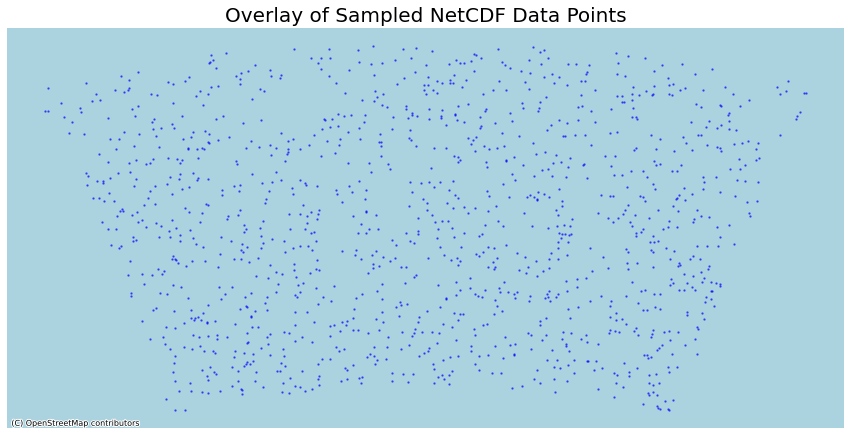

In [7]:
gdf_points = gdf_points.to_crs(epsg=4326)
counties = counties.to_crs(epsg=4326)
ba_subregions = ba_subregions.to_crs(epsg=4326)

# Sample a fraction of the points for a less cluttered map
gdf_points_sampled = gdf_points.sample(frac=0.01)  # Adjust frac as needed

fig, ax = plt.subplots(figsize=(15, 15))

# Plot sampled points from NetCDF data
gdf_points_sampled.plot(ax=ax, color='blue', markersize=2, alpha=0.5, label='NetCDF Data Points Sampled')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set title and adjust plot
ax.set_title('Overlay of Sampled NetCDF Data Points', fontsize=20)

# Remove axis for a cleaner look
ax.set_axis_off()

plt.show()


In [38]:
gdf_points_with_county

Time   Latitude    Longitude  \
0      2060-01-01 01:00:00   21.04686   -120.97156   
1      2060-01-01 01:00:00  21.073246   -120.86305   
2      2060-01-01 01:00:00  21.099514  -120.754486   
3      2060-01-01 01:00:00  21.125668   -120.64584   
4      2060-01-01 01:00:00  21.151703   -120.53714   
...                    ...        ...          ...   
126771 2060-01-01 01:00:00  51.667313   -60.859924   
126772 2060-01-01 01:00:00  51.627647   -60.702576   
126773 2060-01-01 01:00:00  51.587803    -60.54544   
126774 2060-01-01 01:00:00  51.547794    -60.38852   
126775 2060-01-01 01:00:00  51.507603   -60.231842   

                           geometry         T2            Q2    SWDOWN  \
0       POINT (-120.97156 21.04686)   296.8221   0.015045315  94.54849   
1       POINT (-120.86305 21.07325)  296.81345   0.015027003  92.85902   
2       POINT (-120.75449 21.09951)  296.80435   0.015008815  91.17697   
3       POINT (-120.64584 21.12567)  296.79492   0.014989832  89.51024   
4       POINT (-120.53714 21.15170)   296.7806    0.01497129  87.84994   
...                             ...        ...           ...       ...   
126771   POINT (-60.85992 51.66731)   275.9516  0.0044978596       0.0   
126772   POINT (-60.70258 51.62765)  276.33566   0.004584186       0.0   
126773   POINT (-60.54544 51.58780)  276.41513  0.0046168943       0.0   
126774   POINT (-60.38852 51.54779)  276.85315   0.004712313       0.0   
126775   POINT (-60.23184 51.50760)  277.77545   0.004880084       0.0   

              GLW       WSPD   FIPS  index_right CNTRL_AREA  
0          349.63   7.688218  00nan          NaN        NaN  
1        349.3631  7.6723022  00nan          NaN        NaN  
2         349.099  7.6333475  00nan          NaN        NaN  
3        348.7426   7.617999  00nan          NaN        NaN  
4       348.35385  7.6193123  00nan          NaN        NaN  
...           ...        ...    ...          ...        ...  
126771  246.66837  7.6050253  00nan          NaN        NaN  
126772  248.17838  7.8656588  00nan          NaN        NaN  
126773  248.72592    8.28823  00nan          NaN        NaN  
126774  250.46295   8.005387  00nan          NaN        NaN  
126775  254.54521   6.287792  00nan          NaN        NaN  

[194636 rows x 12 columns]

In [39]:
ba_subregions[['geometry', 'CNTRL_AREA']]

geometry  \
0     POLYGON ((-10168715.997 4223699.320, -10168713...   
1     MULTIPOLYGON (((-10538178.657 4617676.536, -10...   
2     POLYGON ((-10631923.077 4639579.579, -10631922...   
3     POLYGON ((-10969707.601 3471696.036, -10969536...   
4     POLYGON ((-10880833.968 4430744.798, -10881077...   
...                                                 ...   
2944  MULTIPOLYGON (((-9859435.759 5589514.800, -985...   
2945  MULTIPOLYGON (((-9451193.745 5152182.141, -944...   
2946  MULTIPOLYGON (((-10619014.957 4296973.754, -10...   
2947  MULTIPOLYGON (((-10187345.454 5637228.388, -10...   
2948  MULTIPOLYGON (((-10942602.530 4077604.592, -10...   

                                             CNTRL_AREA  
0     MIDCONTINENT INDEPENDENT TRANSMISSION SYSTEM O...  
1                                  SOUTHWEST POWER POOL  
2                                  SOUTHWEST POWER POOL  
3           ELECTRIC RELIABILITY COUNCIL OF TEXAS, INC.  
4                                  SOUTHWEST POWER POOL  
...                                                 ...  
2944  MIDCONTINENT INDEPENDENT TRANSMISSION SYSTEM O...  
2945  MIDCONTINENT INDEPENDENT TRANSMISSION SYSTEM O...  
2946                               SOUTHWEST POWER POOL  
2947  MIDCONTINENT INDEPENDENT TRANSMISSION SYSTEM O...  
2948                               SOUTHWEST POWER POOL  

[2949 rows x 2 columns]

In [26]:
# Assuming 'grouped_with_pop' contains a 'FIPS' column and a 'CNTRL_AREA' column for the majority control area
# First, ensure the 'FIPS' column in both DataFrames is of the same data type for a successful merge
counties['FIPS'] = counties['FIPS'].astype(str)
grouped_with_pop['FIPS'] = grouped_with_pop['FIPS'].astype(str)

# Merge the 'grouped_with_pop' DataFrame with the 'counties' GeoDataFrame to get geometries for plotting
merged_df = counties.merge(grouped_with_pop, on='FIPS')

# Ensure the merged DataFrame is in the correct CRS for plotting with contextily
merged_df = merged_df.to_crs(epsg=3857)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each county colored by its control area ('CNTRL_AREA' value)
merged_df.plot(ax=ax, column='CNTRL_AREA', categorical=True, legend=True, 
               edgecolor='black', linewidth=1, legend_kwds={'bbox_to_anchor': (1, 1), 'loc': 'upper left'})

# Add a basemap for better context
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Adjust the plot's limits to fit the geometries
ax.set_xlim(merged_df.total_bounds[[0, 2]])
ax.set_ylim(merged_df.total_bounds[[1, 3]])

# Add titles and labels as needed
ax.set_title('Control Area by County', fontsize=20)

# Remove axis for a cleaner look
ax.axis('off')

plt.tight_layout()
plt.show()


NameError: name 'majority_cntrl_area' is not defined

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy.interpolate import interp1d
import netCDF4 as nc
from shapely.geometry import Point
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Define paths
shapefile_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/Electric_Retail_Service_Territories.shp'
county_shapefile_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/Electric_Retail_Service_Territories.shp'
population_data_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/ssp3_county_population.csv'
nc_file_path = '/Users/ansonkong/Downloads/tgw_wrf_rcp85hotter_hourly_2060-01-01_01_00_00.nc'

# Load geographical data
ba_subregions = gpd.read_file(shapefile_path).to_crs(epsg=3857)
counties = gpd.read_file(county_shapefile_path).to_crs(epsg=3857)  # Ensure CRS matches ba_subregions for spatial join
counties = counties.rename(columns={'ID': 'FIPS'})

# Load and prepare population data (if needed for further analysis)
population_data = pd.read_csv(population_data_path)

# Perform interpolation for each FIPS code (if needed for further analysis)
# Skipping detailed interpolation steps for brevity

# Open NetCDF file (if needed for environmental variables or time-specific data)
ds = nc.Dataset(nc_file_path, 'r')

# Assuming 'Times' is the time variable and focusing on one time period
times_array = ds.variables['Times'][:]  # Assuming 'Times' is the time variable
times_str_list = [b''.join(times_array[t]).decode('ascii') for t in range(times_array.shape[0])]
times = pd.to_datetime(times_str_list, format='%Y-%m-%d_%H:%M:%S')
year_of_interest = str(times[0].year)

# Since focusing on mapping without environmental variables, skip processing NetCDF data points

# Perform a spatial join to map each county to its corresponding control area
gdf_mapping = gpd.sjoin(counties[['geometry', 'FIPS']], ba_subregions[['geometry', 'CNTRL_AREA']], how='left', op='intersects')

# Drop unnecessary columns and duplicates to finalize the mapping
gdf_mapping = gdf_mapping[['FIPS', 'CNTRL_AREA']].drop_duplicates()

# Save the mapping to a CSV file
mapping_file_path = '/Users/ansonkong/Downloads/county_control_area_mapping.csv'
gdf_mapping.to_csv(mapping_file_path, index=False)

print(f"Mapping saved to '{mapping_file_path}'.")

# Close the NetCDF dataset if no longer needed
ds.close()


/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Mapping saved to '/Users/ansonkong/Downloads/county_control_area_mapping.csv'.


In [16]:
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy.interpolate import interp1d
import netCDF4 as nc
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Define paths
shapefile_path = '/Users/ansonkong/Downloads/merradownload-master/shapefile/updated_base_geometries.shp'
county_shapefile_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/Electric_Retail_Service_Territories.shp'
population_data_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/ssp3_county_population.csv'
nc_file_path = '/Users/ansonkong/Downloads/tgw_wrf_rcp85hotter_hourly_2060-01-01_01_00_00.nc'

# Load geographical data
ba_subregions = gpd.read_file(shapefile_path).to_crs(epsg=4326)
counties = gpd.read_file(county_shapefile_path).to_crs(epsg=4326)

# Load and prepare population data (if needed for further analysis)
population_data = pd.read_csv(population_data_path)

# Open NetCDF file
ds = nc.Dataset(nc_file_path, 'r')

# Accessing and cleaning the 'Times' variable for a single time period
times_array = ds.variables['Times'][:]  # Assuming 'Times' is the time variable
times_str_list = [b''.join(times_array[t]).decode('ascii') for t in range(times_array.shape[0])]
times = pd.to_datetime(times_str_list, format='%Y-%m-%d_%H:%M:%S')

# Select a specific time point
time_step = 0  # For example, the first time point

# Extract latitude and longitude coordinates for the selected time point
lats = ds.variables['XLAT'][time_step, :, :]
lons = ds.variables['XLONG'][time_step, :, :]

# Flatten the latitude and longitude arrays and create Point geometries
points = [Point(lon, lat) for lat, lon in zip(np.ravel(lats), np.ravel(lons))]

# Create a GeoDataFrame from these points
gdf_points = gpd.GeoDataFrame(geometry=points, crs='EPSG:4326')

# Spatially join points to control areas
points_with_control_area = gpd.sjoin(gdf_points, ba_subregions, how='left', op='intersects')

# Spatially join points to counties
points_with_counties = gpd.sjoin(gdf_points, counties[['geometry', 'ID']], how='left', op='intersects')

# Combine the results to associate points with both their county FIPS and control area
combined = points_with_counties.merge(points_with_control_area[['rb']], left_index=True, right_index=True, how='left')

# Aggregate by county FIPS and determine the majority control area for each county
majority_control_area = combined.groupby('ID')['rb'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).reset_index()

# Display the result
print(majority_control_area)

# Optionally, save the result to a CSV file
majority_control_area.to_csv('/Users/ansonkong/Downloads/county_control_area_mapping.csv', index=False)

# Close the NetCDF dataset
ds.close()


/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


         ID    rb
0      1000   p85
1     10000   p53
2     10005   p53
3     10009   p65
4     10012   p50
...     ...   ...
2158    NA5  p140
2159    NA6  p141
2160    NA7  p141
2161    NA8  p140
2162    NA9  p140

[2163 rows x 2 columns]


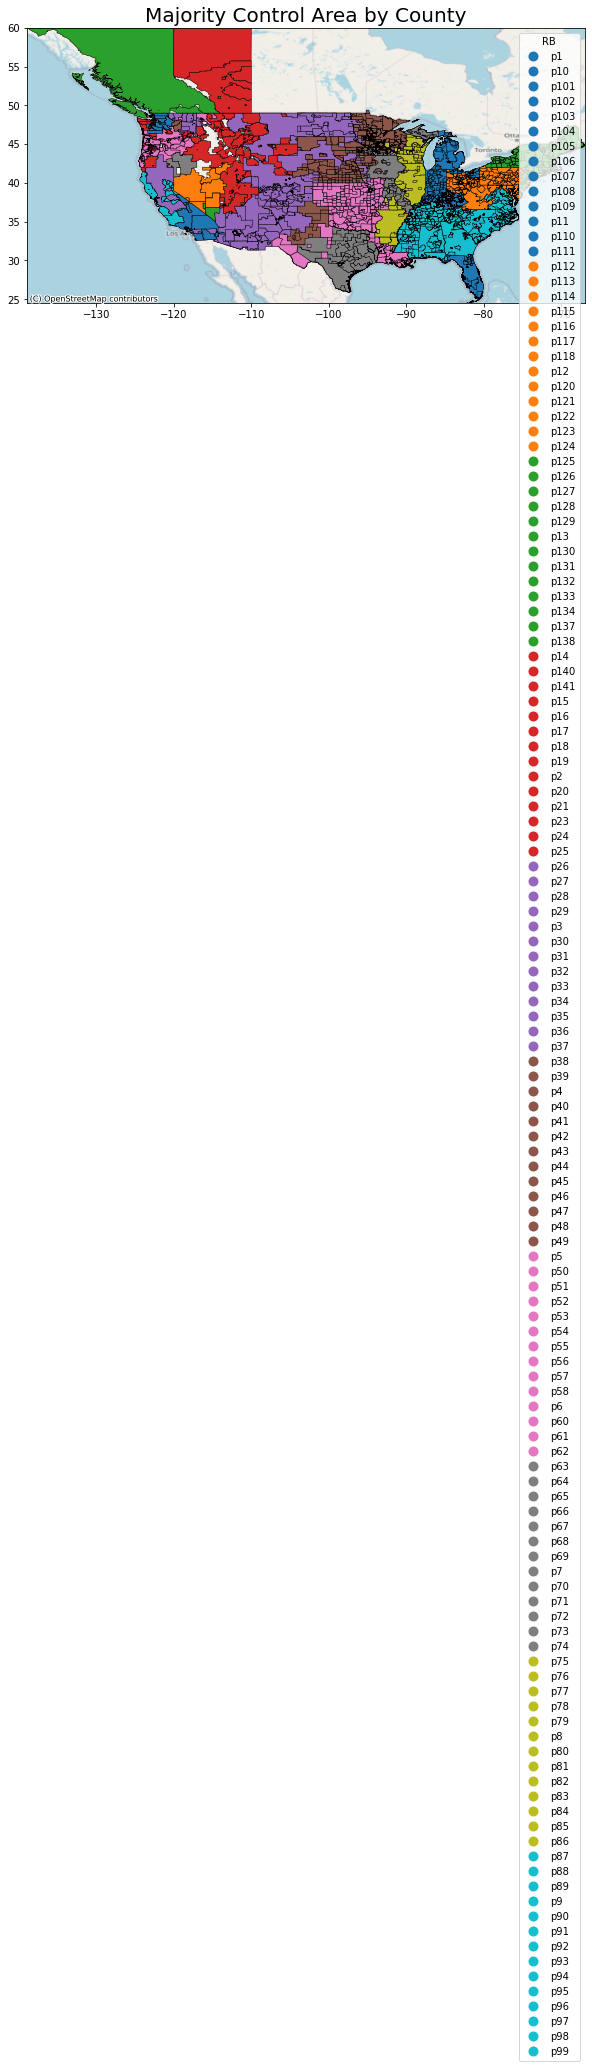

In [18]:
# Merge the majority_control_area DataFrame with the counties GeoDataFrame to get geometries
counties_with_majority_rb = counties.merge(majority_control_area, left_on='ID', right_on='ID')
import contextily as ctx
# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Ensure there's an 'rb' column after the merge; if not, the merge might have failed
if 'rb' in counties_with_majority_rb.columns:
    # Plot each 'rb' with the same color and draw county boundaries
    counties_with_majority_rb.plot(ax=ax, column='rb', categorical=True, legend=True, 
                                   edgecolor='black', linewidth=0.5, legend_kwds={'title': 'RB'})
    
    # Optionally, add a basemap for better context
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=counties_with_majority_rb.crs.to_string())
    
    # Adjust the plot's limits to fit the geometries
    ax.set_xlim(counties_with_majority_rb.total_bounds[[0, 2]])
    ax.set_ylim(counties_with_majority_rb.total_bounds[[1, 3]])
    
    # Add titles and labels as needed
    ax.set_title('Majority Control Area by County', fontsize=20)
else:
    print("The 'rb' column was not found in the merged DataFrame. Check the merge operation.")

plt.show()



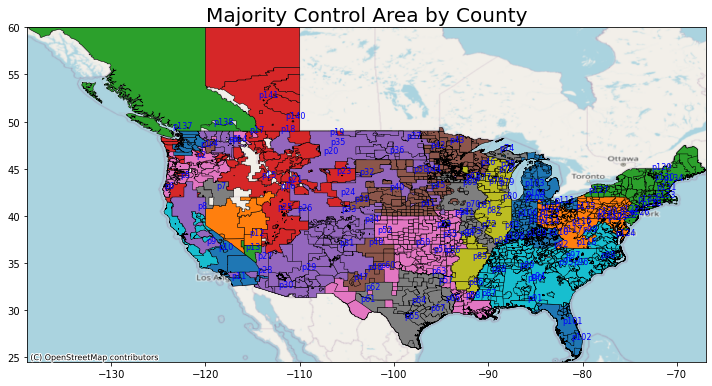

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))

if 'rb' in counties_with_majority_rb.columns:
    # Plot each 'rb' with the same color and draw county boundaries
    plot = counties_with_majority_rb.plot(ax=ax, column='rb', categorical=True, legend=False, 
                                          edgecolor='black', linewidth=0.5)
    
    # Optionally, add a basemap for better context
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=counties_with_majority_rb.crs.to_string())
    
    # Adjust the plot's limits to fit the geometries
    ax.set_xlim(counties_with_majority_rb.total_bounds[[0, 2]])
    ax.set_ylim(counties_with_majority_rb.total_bounds[[1, 3]])
    
    # Add titles and labels as needed
    ax.set_title('Majority Control Area by County', fontsize=20)
    
    # Keep track of which 'rb' values have been labeled
    labeled_rb = set()
    
    # Annotate each county with its 'rb' value, ensuring each 'rb' is labeled only once
    for idx, row in counties_with_majority_rb.iterrows():
        if row['rb'] not in labeled_rb:
            # Use the centroid of each county's geometry for the label's location
            centroid = row.geometry.centroid
            ax.annotate(text=row['rb'], xy=(centroid.x, centroid.y), xytext=(3, 3), textcoords="offset points",
                        ha='center', fontsize=8, color='blue')
            labeled_rb.add(row['rb'])

else:
    print("The 'rb' column was not found in the merged DataFrame. Check the merge operation.")

plt.tight_layout()
plt.show()


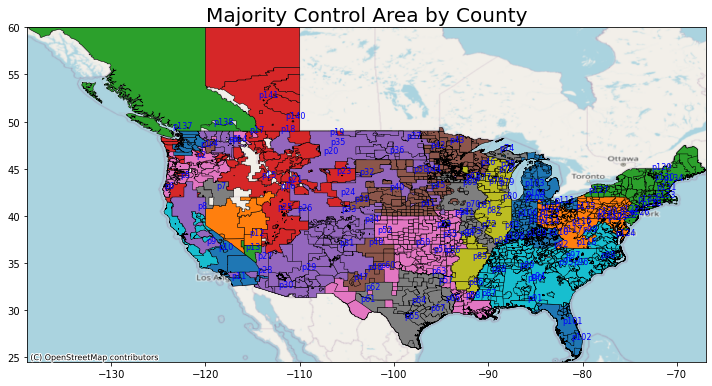

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))

if 'rb' in counties_with_majority_rb.columns:
    counties_with_majority_rb.plot(ax=ax, column='rb', categorical=True, legend=False, 
                                   edgecolor='black', linewidth=0.5)
    
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=counties_with_majority_rb.crs.to_string())
    
    ax.set_xlim(counties_with_majority_rb.total_bounds[[0, 2]])
    ax.set_ylim(counties_with_majority_rb.total_bounds[[1, 3]])
    
    ax.set_title('Majority Control Area by County', fontsize=20)
    
    labeled_rb = set()
    for idx, row in counties_with_majority_rb.iterrows():
        if row['rb'] not in labeled_rb:
            centroid = row.geometry.centroid
            ax.annotate(text=row['rb'], xy=(centroid.x, centroid.y), xytext=(3, 3), textcoords="offset points",
                        ha='center', fontsize=8, color='blue')
            labeled_rb.add(row['rb'])

else:
    print("The 'rb' column was not found in the merged DataFrame. Check the merge operation.")

plt.tight_layout()

# Specify a high DPI value for high resolution
dpi_value = 1200  # Adjust this value as needed for your specific requirements

# Save the figure with the specified DPI
output_figure_path = '/Users/ansonkong/Downloads/majority_control_area_high_res.png'
fig.savefig(output_figure_path, dpi=dpi_value)

plt.show()





In [14]:
states_in_usa_gdf 

WKT_left cendiv_left  \
109  MULTIPOLYGON (((-75.4897537368881 39.831066551...        None   
111  MULTIPOLYGON (((-109.050804791622 39.370820821...        None   
113  MULTIPOLYGON (((-114.050538017437 36.817261954...        None   
114  MULTIPOLYGON (((-72.4714677484625 40.984920541...        None   
115  MULTIPOLYGON (((-83.115644257502 34.9935358264...        None   
116  MULTIPOLYGON (((-84.2385684346539 36.597087441...        None   
117  MULTIPOLYGON (((-117.259447474842 32.923240705...        None   
118  MULTIPOLYGON (((-83.7335132884315 38.647831314...        None   
121  MULTIPOLYGON (((-99.5871640761212 36.999638290...        None   
123  MULTIPOLYGON (((-94.8964680274868 29.266669195...        None   
125  MULTIPOLYGON (((-117.005994424536 46.306176062...        None   
126  MULTIPOLYGON (((-117.058851566247 41.999764555...        None   
127  MULTIPOLYGON (((-105.124164955371 45.000418336...        None   
129  MULTIPOLYGON (((-103.090892243764 43.000755768...        None   
130  MULTIPOLYGON (((-80.4523888510381 32.343868768...        None   
131  MULTIPOLYGON (((-88.9305254134183 42.494865128...        None   
133  MULTIPOLYGON (((-101.199145955676 48.999563701...        None   
134  MULTIPOLYGON (((-78.0062406216531 33.862396562...        None   
137  MULTIPOLYGON (((-71.1925049991234 45.248206792...        None   
138  MULTIPOLYGON (((-95.7660821239057 40.544091130...        None   
140  MULTIPOLYGON (((-104.054621954846 43.383810954...        None   
141  MULTIPOLYGON (((-81.6830124455567 24.560595209...        None   
142  MULTIPOLYGON (((-74.4622161234398 39.343634761...        None   
143  MULTIPOLYGON (((-71.5611414715648 41.157319421...        None   
144  MULTIPOLYGON (((-85.434591772986 34.1495325721...        None   
145  MULTIPOLYGON (((-91.0957892120788 33.427802672...        None   
146  MULTIPOLYGON (((-80.8757756188371 37.386957065...        None   
147  MULTIPOLYGON (((-103.041567002866 35.618570027...        None   
150  MULTIPOLYGON (((-110.528105012168 31.332956483...        None   
151  MULTIPOLYGON (((-79.8173573188576 36.542630872...        None   
156  MULTIPOLYGON (((-70.5582573377582 41.453499320...        None   
157  MULTIPOLYGON (((-90.6902673050138 42.604013289...        None   
158  MULTIPOLYGON (((-70.0025424215367 43.781537182...        None   
159  MULTIPOLYGON (((-72.4965625802848 45.008545131...        None   
160  MULTIPOLYGON (((-76.2033242530119 38.296153904...        None   
161  MULTIPOLYGON (((-111.324528053346 44.723515600...        None   
162  MULTIPOLYGON (((-85.5085394998516 41.759421333...        None   
165  MULTIPOLYGON (((-89.3850308862645 36.579964415...        None   
166  MULTIPOLYGON (((-91.270764089894 43.8131331283...        None   
167  MULTIPOLYGON (((-84.8122983820771 39.922609721...        None   
168  MULTIPOLYGON (((-87.5261477147247 40.977865319...        None   
169  MULTIPOLYGON (((-91.4698694958032 31.623565310...        None   
170  MULTIPOLYGON (((-102.078898126676 36.993138421...        None   
171  MULTIPOLYGON (((-94.613306324398 38.4367641240...        None   
172  MULTIPOLYGON (((-71.7986426657545 42.001248816...        None   
173  MULTIPOLYGON (((-89.5520336291582 36.515038911...        None   
177  MULTIPOLYGON (((-77.5302263502763 39.720079275...        None   
178  MULTIPOLYGON (((-89.1845117746433 29.100916668...        None   

    country_left rto_left customreg_left usda_left nercr_left st_left  \
109         None     None           None      None       None      DE   
111         None     None           None      None       None      UT   
113         None     None           None      None       None      NV   
114         None     None           None      None       None      NY   
115         None     None           None      None       None      GA   
116         None     None           None      None       None      TN   
117         None     None           None      None       None      CA   
118         None     None      

In [3]:
gdf_mapping

FIPS                                         CNTRL_AREA
0      1000  MIDCONTINENT INDEPENDENT TRANSMISSION SYSTEM O...
1     10000                               SOUTHWEST POWER POOL
1     10000              ASSOCIATED ELECTRIC COOPERATIVE, INC.
2     10005                               SOUTHWEST POWER POOL
2     10005              ASSOCIATED ELECTRIC COOPERATIVE, INC.
...     ...                                                ...
2945   3915  MIDCONTINENT INDEPENDENT TRANSMISSION SYSTEM O...
2946  20163                               SOUTHWEST POWER POOL
2946  20163              ASSOCIATED ELECTRIC COOPERATIVE, INC.
2947   1866  MIDCONTINENT INDEPENDENT TRANSMISSION SYSTEM O...
2948  20061                               SOUTHWEST POWER POOL

[6125 rows x 2 columns]

In [ ]:
# Save the aggregated results
results_file_path = '/Users/ansonkong/Downloads/weighted_aggregated_data_with_time.csv'
weighted_averages_df.to_csv(results_file_path, index=False)
print(f"Data aggregation complete. Check '{results_file_path}'")

In [12]:
print(counties.columns)


Index(['OBJECTID', 'ID', 'NAME', 'ADDRESS', 'CITY', 'STATE', 'ZIP',
       'TELEPHONE', 'TYPE', 'COUNTRY', 'NAICS_CODE', 'NAICS_DESC', 'SOURCE',
       'SOURCEDATE', 'VAL_METHOD', 'VAL_DATE', 'WEBSITE', 'REGULATED',
       'CNTRL_AREA', 'PLAN_AREA', 'HOLDING_CO', 'SUMMR_PEAK', 'WINTR_PEAK',
       'SUMMER_CAP', 'WINTER_CAP', 'NET_GEN', 'PURCHASED', 'NET_EX',
       'RETAIL_MWH', 'WSALE_MWH', 'TOTAL_MWH', 'TRANS_MWH', 'CUSTOMERS',
       'YEAR', 'Shape__Are', 'Shape__Len', 'geometry'],
      dtype='object')


In [13]:
print(counties.head()


   OBJECTID     ID                      NAME            ADDRESS  \
0         1   1000    CITY OF AUGUSTA - (AR)      NOT AVAILABLE   
1         2  10000              EVERGY METRO   1200 MAIN STREET   
2         3  10005  EVERGY KANSAS SOUTH, INC  818 KANSAS AVENUE   
3         4  10009  KARNES ELECTRIC COOP INC   1007 N. HWY. 123   
4         5  10012         KAY ELECTRIC COOP      300 W. DOOLIN   

            CITY STATE            ZIP       TELEPHONE            TYPE COUNTRY  \
0  NOT AVAILABLE    AR  NOT AVAILABLE   NOT AVAILABLE       MUNICIPAL     USA   
1    KANSAS CITY    KS          64105   NOT AVAILABLE  INVESTOR OWNED     USA   
2         TOPEKA    KS          66612   NOT AVAILABLE  INVESTOR OWNED     USA   
3    KARNES CITY    TX          78118  (830) 780-3952     COOPERATIVE     USA   
4      BLACKWELL    OK          74631  (580) 363-1260     COOPERATIVE     USA   

   ...  NET_EX RETAIL_MWH WSALE_MWH TOTAL_MWH TRANS_MWH CUSTOMERS  YEAR  \
0  ... -999999    -999999   -999999

In [2]:
results_file_path = '/Users/ansonkong/Downloads/aggregated_data_with_time.csv'
results_df.to_csv(results_file_path, index=False)
print(f"Data aggregation complete. Check '{results_file_path}'")

Data aggregation complete. Check '/Users/ansonkong/Downloads/aggregated_data_with_time.csv'


In [34]:
# Check for available attributes in the 'Times' variable
print(ds.variables['Times'].ncattrs())

# If 'units' is not listed, check the global attributes or other related variables
print(ds.ncattrs())


[]
['TITLE', 'START_DATE', 'SIMULATION_START_DATE', 'WEST-EAST_GRID_DIMENSION', 'SOUTH-NORTH_GRID_DIMENSION', 'BOTTOM-TOP_GRID_DIMENSION', 'DX', 'DY', 'AERCU_OPT', 'AERCU_FCT', 'IDEAL_CASE', 'DIFF_6TH_SLOPEOPT', 'AUTO_LEVELS_OPT', 'DIFF_6TH_THRESH', 'DZBOT', 'DZSTRETCH_S', 'DZSTRETCH_U', 'SKEBS_ON', 'SPEC_BDY_FINAL_MU', 'USE_Q_DIABATIC', 'GRIDTYPE', 'DIFF_OPT', 'KM_OPT', 'DAMP_OPT', 'DAMPCOEF', 'KHDIF', 'KVDIF', 'MP_PHYSICS', 'RA_LW_PHYSICS', 'RA_SW_PHYSICS', 'SF_SFCLAY_PHYSICS', 'SF_SURFACE_PHYSICS', 'BL_PBL_PHYSICS', 'CU_PHYSICS', 'SF_LAKE_PHYSICS', 'SURFACE_INPUT_SOURCE', 'SST_UPDATE', 'GRID_FDDA', 'GFDDA_INTERVAL_M', 'GFDDA_END_H', 'GRID_SFDDA', 'SGFDDA_INTERVAL_M', 'SGFDDA_END_H', 'HYPSOMETRIC_OPT', 'USE_THETA_M', 'GWD_OPT', 'SF_URBAN_PHYSICS', 'SF_SURFACE_MOSAIC', 'SF_OCEAN_PHYSICS', 'SHCU_PHYSICS', 'MFSHCONV', 'FEEDBACK', 'SMOOTH_OPTION', 'SWRAD_SCAT', 'W_DAMPING', 'ADAPT_DT_START', 'ADAPT_DT_MAX', 'ADAPT_DT_MIN', 'RADT', 'BLDT', 'CUDT', 'AER_OPT', 'SWINT_OPT', 'AER_TYPE', 'AER_

In [25]:
output_df[['T2', 'Q2', 'SWDOWN', 'GLW',
       'WSPD']]

T2  Q2  SWDOWN  GLW  WSPD
0    NaN NaN     NaN  NaN   NaN
1    NaN NaN     NaN  NaN   NaN
2    NaN NaN     NaN  NaN   NaN
3    NaN NaN     NaN  NaN   NaN
4    NaN NaN     NaN  NaN   NaN
...   ..  ..     ...  ...   ...
2944 NaN NaN     NaN  NaN   NaN
2945 NaN NaN     NaN  NaN   NaN
2946 NaN NaN     NaN  NaN   NaN
2947 NaN NaN     NaN  NaN   NaN
2948 NaN NaN     NaN  NaN   NaN

[2949 rows x 5 columns]

In [ ]:
output_df

In [ ]:
import netCDF4 as nc

ds = nc.Dataset('wrf_output_file.nc', 'r')
print(ds)  # Prints an overview of the file's contents


In [ ]:
xlat = ds.variables['XLAT'][0, :, :]  # Assuming time dimension is first
xlong = ds.variables['XLONG'][0, :, :]

# Check if the grid is regular (simple spacing) or irregular (varying spacing)
print(xlat.shape)
print(xlong.shape)


In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# Convert grid points to geospatial data
points = [Point(lon, lat) for lat, lon in zip(xlat.flatten(), xlong.flatten())]
gdf = gpd.GeoDataFrame({'geometry': points}, crs="EPSG:4326")


In [20]:

import rasterio
from rasterio.mask import mask
# Example function to match and average NetCDF data to shapefile polygons
def match_and_average(nc_data, ba_subregions, var_names):
    # Assuming the NetCDF data grid has already been aligned with the shapefile's CRS
    # This part is highly data-dependent and may require using rasterio to read or transform the grid
    
    averages = {var: [] for var in var_names}  # To store averages for each variable
    
    for _, row in ba_subregions.iterrows():
        # Create mask for current polygon
        # This is a simplified conceptual step
        geom = row['geometry']
        out_image, out_transform = rasterio.mask.mask(nc_data, [geom], crop=True)
        out_mask = out_image.data.mask
        
        # Calculate averages for each variable
        for var in var_names:
            masked_data = np.ma.array(nc_data[var], mask=out_mask)
            averages[var].append(masked_data.mean())
    
    # Return averages as a DataFrame
    return pd.DataFrame(averages)

# Mock-up: Replace 'nc_data' with actual raster data aligned with shapefile CRS
averaged_data = match_and_average(nc_data, ba_subregions, variables)

# Add 'CNTRL_AREA' to averaged data for grouping
averaged_data['CNTRL_AREA'] = ba_subregions['CNTRL_AREA']


AttributeError: 'dict' object has no attribute 'nodata'

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import wkt
import netCDF4 as nc
from shapely.geometry import Point
import contextily as ctx
import matplotlib.pyplot as plt

# Load and prepare geographic data
shapefile_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/Electric_Retail_Service_Territories.shp'
county_shapefile_path = shapefile_path  # Same as shapefile_path in this case
nc_file_path = '/Users/ansonkong/Downloads/tgw_wrf_rcp85hotter_hourly_2060-01-01_01_00_00.nc'

counties = gpd.read_file(county_shapefile_path).to_crs(epsg=4326)

# Load NetCDF file and extract data points
ds = nc.Dataset(nc_file_path, 'r')
time_step = 0
lats = ds.variables['XLAT'][time_step, :, :]
lons = ds.variables['XLONG'][time_step, :, :]
gdf_points = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in zip(np.ravel(lats), np.ravel(lons))], crs='EPSG:4326')

# Perform spatial join to associate points with counties
gdf_points_with_county = gpd.sjoin(gdf_points, counties, how='left', op='intersects')

# Assuming 'ID' column in counties matches 'CountyFIPS' in gdf_points_with_county for the merge key
gdf_points_with_county['CountyFIPS'] = gdf_points_with_county['index_right'].astype(str)

# Determine Majority Control Area by County
majority_area_by_county = gdf_points_with_county.groupby('CountyFIPS')['rb'].agg(lambda x: x.mode()[0] if not x.empty else 'No Area').reset_index()

# Merge this information back with the counties GeoDataFrame
counties_with_majority_area = counties.merge(majority_area_by_county, left_on='ID', right_on='CountyFIPS', how='left')

# Convert to Web Mercator CRS for plotting with contextily basemap
counties_with_majority_area = counties_with_majority_area.to_crs(epsg=3857)

# Plotting focused on the USA
fig, ax = plt.subplots(figsize=(15, 10))
counties_with_majority_area.plot(ax=ax, column='rb', alpha=0.5, edgecolor='k', legend=True)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=5)

# Zoom in to the USA
ax.set_xlim([-13884029, -7453304])
ax.set_ylim([2810491, 6338219])

ax.set_title('Majority Control Area by County', fontsize=20)
ax.set_axis_off()

plt.show()

ds.close()

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import wkt
import netCDF4 as nc
from shapely.geometry import Point
import contextily as ctx
import matplotlib.pyplot as plt

# Load and prepare geographic data
shapefile_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/Electric_Retail_Service_Territories.shp'
county_shapefile_path = shapefile_path  # Same as shapefile_path in this case
nc_file_path = '/Users/ansonkong/Downloads/tgw_wrf_rcp85hotter_hourly_2060-01-01_01_00_00.nc'

counties = gpd.read_file(county_shapefile_path).to_crs(epsg=4326)

# Load NetCDF file and extract data points
ds = nc.Dataset(nc_file_path, 'r')
time_step = 0
lats = ds.variables['XLAT'][time_step, :, :]
lons = ds.variables['XLONG'][time_step, :, :]
gdf_points = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in zip(np.ravel(lats), np.ravel(lons))], crs='EPSG:4326')

# Perform spatial join to associate points with counties
gdf_points_with_county = gpd.sjoin(gdf_points, counties, how='left', op='intersects')

# Assuming 'ID' column in counties matches 'CountyFIPS' in gdf_points_with_county for the merge key
gdf_points_with_county['CountyFIPS'] = gdf_points_with_county['index_right'].astype(str)

# Determine Majority Control Area by County
majority_area_by_county = gdf_points_with_county.groupby('CountyFIPS')['rb'].agg(lambda x: x.mode()[0] if not x.empty else 'No Area').reset_index()

# Merge this information back with the counties GeoDataFrame
counties_with_majority_area = counties.merge(majority_area_by_county, left_on='ID', right_on='CountyFIPS', how='left')

# Convert to Web Mercator CRS for plotting with contextily basemap
counties_with_majority_area = counties_with_majority_area.to_crs(epsg=3857)

# Plotting focused on the USA
fig, ax = plt.subplots(figsize=(15, 10))
counties_with_majority_area.plot(ax=ax, column='rb', alpha=0.5, edgecolor='k', legend=True)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=5)

# Zoom in to the USA
ax.set_xlim([-13884029, -7453304])
ax.set_ylim([2810491, 6338219])

ax.set_title('Majority Control Area by County', fontsize=20)
ax.set_axis_off()

plt.show()

ds.close()


In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx

# Load the county shapefile as a GeoDataFrame
county_shapefile_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/Electric_Retail_Service_Territories.shp'
counties_gdf = gpd.read_file(county_shapefile_path)

# Load the mapping CSV
mapping_path = '/Users/ansonkong/Downloads/county_majority_control_area_nan_fips.csv'
mapping_df = pd.read_csv(mapping_path)

# Ensure the FIPS codes are strings for both DataFrames
mapping_df['FIPS'] = mapping_df['FIPS'].astype(str)
counties_gdf['FIPS'] = counties_gdf['ID'].astype(str)

# Merge the mapping with the county geometries
# This time, explicitly ensure the result is treated as a GeoDataFrame
merged_gdf = gpd.GeoDataFrame(counties_gdf.merge(mapping_df, on='FIPS', how='inner'))

# Convert to Web Mercator for plotting with contextily basemap
merged_gdf = merged_gdf.to_crs(epsg=3857)

# Plotting
fig, ax = plt.subplots(figsize=(15, 10))
merged_gdf.plot(ax=ax, column='MajorityArea', alpha=0.5, edgecolor='k', legend=True)  # Assuming 'MajorityArea' is the correct column name from your CSV
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=5)

# Set title and labels
ax.set_title('Majority Control Area by County', fontsize=20)
ax.set_axis_off()

plt.show()

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx

# Load the mapping CSV
mapping_path = '/Users/ansonkong/Downloads/county_control_area_mapping_no_state_fips.csv'
mapping_df = pd.read_csv(mapping_path)

# Load the county shapefile
county_shapefile_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/Electric_Retail_Service_Territories.shp'
counties_gdf = gpd.read_file(county_shapefile_path)

# Ensure the FIPS codes are strings for both DataFrames
mapping_df['FIPS'] = mapping_df['FIPS'].astype(str)
counties_gdf['FIPS'] = counties_gdf['ID'].astype(str)

# Merge the mapping with the county geometries
merged_gdf = counties_gdf.merge(mapping_df, on='FIPS', how='inner')

# Convert to Web Mercator for plotting with contextily basemap
merged_gdf = merged_gdf.to_crs(epsg=3857)

# Plotting
fig, ax = plt.subplots(figsize=(15, 10))
merged_gdf.plot(ax=ax, column='rb', alpha=0.5, edgecolor='k', legend=True)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Focus on USA by setting the x and y limits to the approximate bounding box of the continental USA
# These limits are in Web Mercator coordinates
ax.set_xlim([-13884029, -7453304])
ax.set_ylim([2810491, 6338219])

# Set title and labels
ax.set_title('Majority Control Area by County', fontsize=20)
ax.set_axis_off()

plt.show()

In [ ]:
population_data_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/ssp3_county_population.csv'

population_data = pd.read_csv(population_data_path)
population_data 